# Field Transformation HMC: `ftHMC`

**TODO**:
 - [ ] Still can't reproduce their acceptance rate when running with same parameters
   - [ ] even with `leakyReLU()` as in original implementation
   - [ ] check layers and samplers against original implementation
 - [ ] Keep tuning $\tau$ and $N_{\mathrm{LF}}$ in `ftHMC`
 - [ ] Add quantitative metric $\tau_{\mathrm{int}}$ for $Q$ and look at $\delta Q_{\mathbb{Z}}$
   - [ ] Add $Q_{\mathbb{R}}$ to list of metrics tracked
 - [ ] Build & Test `pytorch.DDP` implementation for data[ ]parallel training
 - [ ] Rewrite `ftHMC` and generic `HMC` to be compatible with batch of samples
   - [ ] Try something like $x_{i+1} = m \odot x'_{i} + (1 - m) \odot x_{i}$
   - [ ] Try rewriting `ftHMC` using generators like in `samplers.make_mcmc_ensemble`
 - [ ] Test symmetry and reversibility explicitly
 - [ ] Update tracking to clearly indicate if a model was loaded from some previously trained experiment
   - [ ] In this case, want to know the prior used to train initial model
   - [ ] `logdir` containing trained model
   - [ ] original `TrainConfig` and `SchedulerConfig`
 - [ ] Try adding `sacred` for additional experiment tracking
   
 
 



### Imports

In [1]:
import os
import sys
import torch

from functools import reduce
from IPython.core.interactiveshell import InteractiveShell

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format ='retina'

InteractiveShell.ast_node_interactivity = "all"


project_dir = os.path.abspath('../../')
if project_dir not in sys.path:
    sys.path.append(project_dir)

import fthmc.utils.io as io
logger = io.Logger()

torch.manual_seed(9)
# torch.set_default_tensor_type(torch.FloatTensor)

#torch.set_num_threads(param.nth)
#torch.set_num_interop_threads(param.nth_interop)
#os.environ["OMP_NUM_THREADS"] = str(param.nth)
#os.environ["KMP_BLOCKTIME"] = "0"
#os.environ["KMP_SETTINGS"] = "1"
#os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

import matplotlib as mpl
import matplotlib.pyplot as plt

from fthmc.train import train
from fthmc.config import Param, TrainConfig, PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_u1_equiv_layers, set_weights
from fthmc.utils.plot_helpers import save_live_plots
from fthmc.utils.logger import Logger

import fthmc.utils.qed_helpers as qed

import datetime

from fthmc.config import LOGS_DIR

mpl.rcParams['text.usetex'] = False
%matplotlib inline

style_file = os.path.abspath('~/.matplotlib/stylelib/molokai.mplstyle')
if os.path.isfile(style_file):
    plt.style.use('~/.matplotlib/stylelib/molokai.mplstyle')
    plt.style.use(style_file)

[17:36:37]  TORCH DEVICE: cuda

            TORCH DTYPE: torch.float32

In [2]:
import seaborn as sns

#sns.set_palette('bright')
sns.set_style('whitegrid')
colors = ['#228BE6', '#FA5252', '#40C057',
          '#FF920B', '#BE4BDB', '#FAB005',
          '#E64980', '#6A777E', '#4C6EF5']
sns.set_palette(colors)

## Define `Param` and `TrainConfig` for training the flow

In [7]:
import numpy as np

from fthmc.config import SchedulerConfig
from fthmc.main import main

#plt.style.use('~/.matplotlib/stylelib/molokai.mplstyle')

L = 8 
BETA = 2.

# -------------------------------------------
# Specify `param` and `train_config` objects
# -------------------------------------------
param = Param(**{
    'L': L, 
    'tau': 0.5,
    'nrun': 1,
    'beta': BETA,
    'nstep': 5,
    'ntraj': 1000,
    'nprint': 100,
    'seed': 1331,
    #'nth': 0,
    #'nth_interop': 0
})

train_config = TrainConfig(**{
    'L': L,
    'beta': BETA,
    'n_era': 10,
    'n_epoch': 100,
    'activation_fn': 'silu',
    'n_layers': 16,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8],
    'kernel_size': 3,
    'batch_size': 64,
    'print_freq': 100,
    'plot_freq': 50,
    'log_freq': 50,
})

scheduler_config = SchedulerConfig(**{
    'factor': 0.95,
    'patience': 20,
    'min_lr': 5e-6,
    'verbose': True,
})

os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= (
    "granularity=fine,verbose,compact,1,0"
)
#torch.set_num_threads(int(param.nth))
#torch.set_num_interop_threads(int(param.nth_interop))
#os.environ["OMP_NUM_THREADS"] = str(param.nth)

## Run HMC using `Param` defined above

───────────────────── Running HMC for 1 runs, of 1000 trajectories each ─────────────────────

[17:40:18]  Creating directory:                                                              
            ../../logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n1000_t0.5_s5/2021-07-08-174018

[17:40:18]  Creating directory:                                                              
            ../../logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n1000_t0.5_s5/2021-07-08-174018/plots

[17:40:18]  Param:                                                                           
            ----------------                                                                 
            beta=2.0                                                                         
            L=8                                                                              
            tau=0.5                                                                          
            nstep=5                                                                          
            ntraj=1000                                                                       
            nrun=1                                                                           
            nprint=100                                                                       
            seed=1331                                                                        
            randinit=False                                                                   
            nth_interop=2                                                                    
            nth=2                                                                            
            lat=[8, 8]                                                                       
            nd=2                                                                             
            shape=[2, 8, 8]                                                                  
            volume=64                                                                        
            dt=0.1                                                                           
            logdir=/lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n
            1000_t0.5_s5

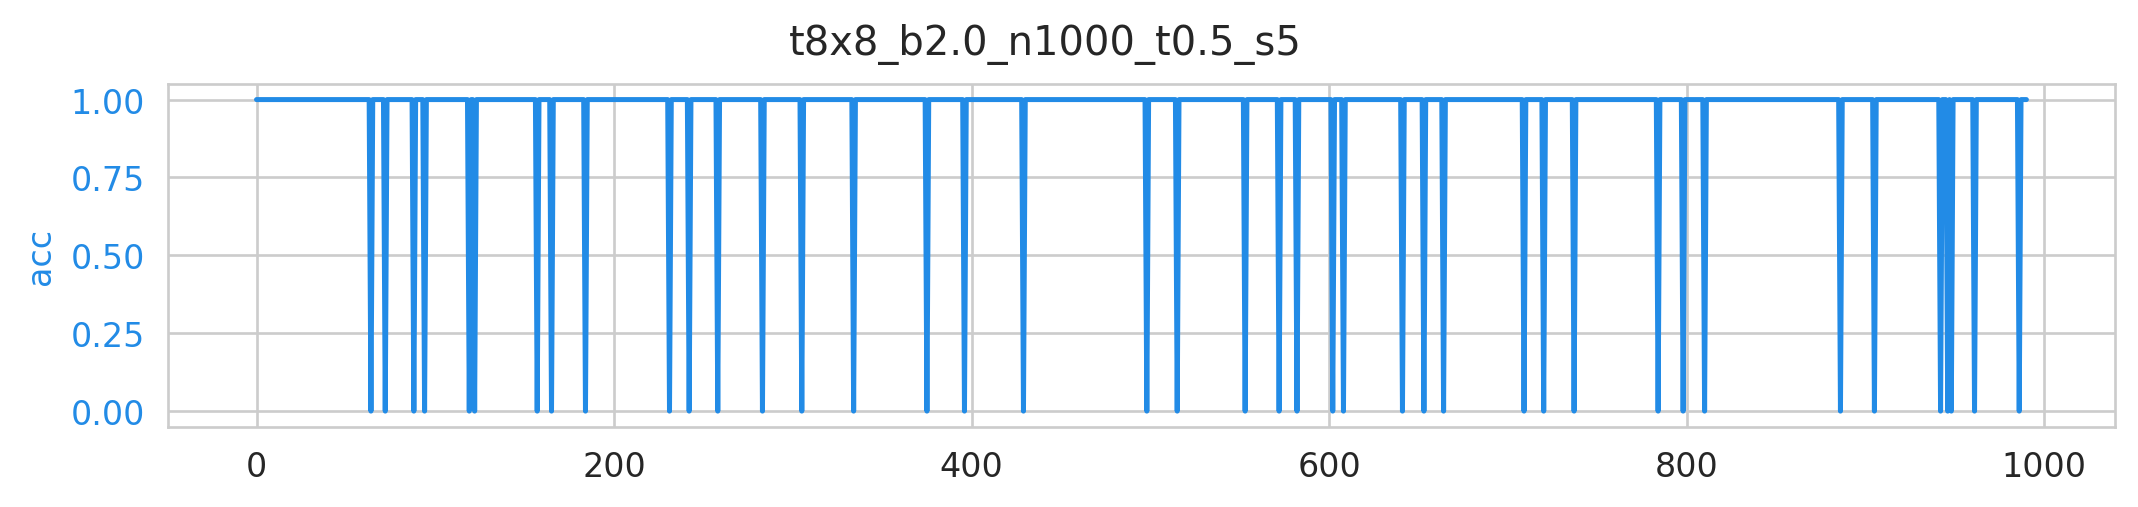

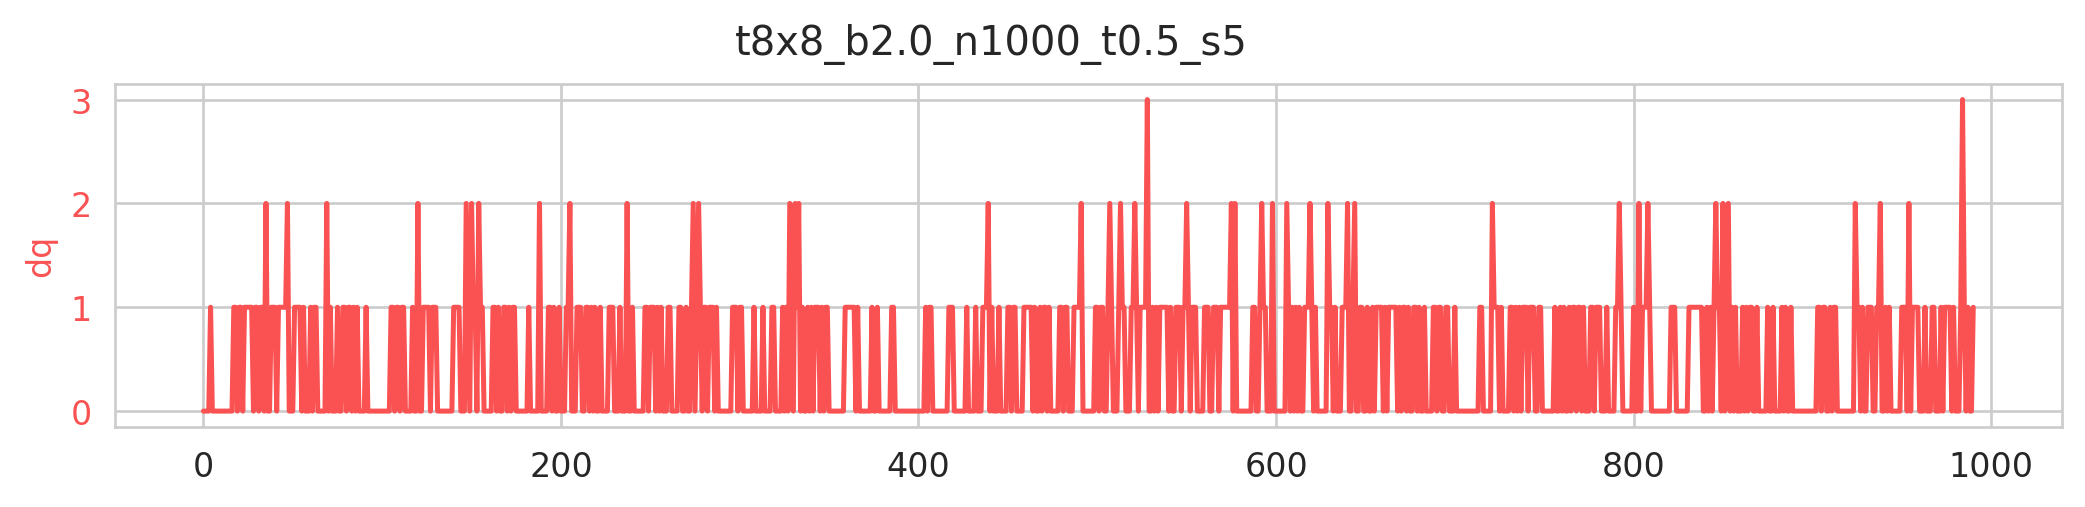

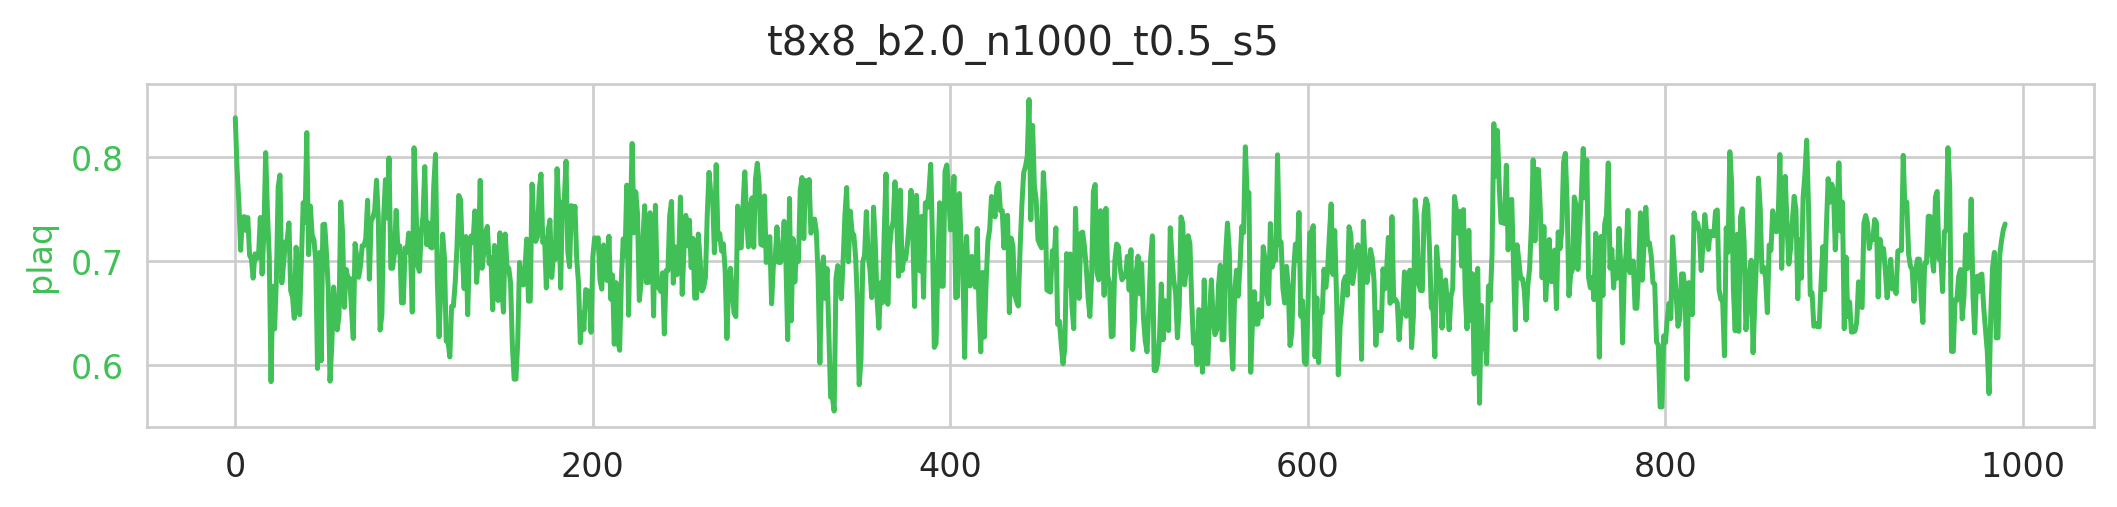

──────────────────────────────── RUN: 0, last took: 0 m 0 s ─────────────────────────────────

[17:40:19]  plaq=1.000 q=0.000

            traj=2 dt=0.004 acc=1.000 dH=-0.110 plaq=0.789 q=0 dq=0.000

[17:40:25]  traj=102 dt=0.004 acc=1.000 dH=-0.083 plaq=0.759 q=0 dq=0.000

[17:40:31]  traj=202 dt=0.004 acc=1.000 dH=0.070 plaq=0.723 q=1 dq=0.000

[17:40:37]  traj=302 dt=0.004 acc=1.000 dH=0.067 plaq=0.696 q=1 dq=1.000

[17:40:44]  traj=402 dt=0.004 acc=1.000 dH=0.087 plaq=0.742 q=0 dq=0.000

[17:40:49]  traj=502 dt=0.004 acc=1.000 dH=0.017 plaq=0.711 q=0 dq=0.000

[17:40:56]  traj=602 dt=0.004 acc=1.000 dH=0.082 plaq=0.727 q=0 dq=0.000

[17:41:02]  traj=702 dt=0.004 acc=1.000 dH=0.142 plaq=0.676 q=0 dq=0.000

[17:41:09]  traj=802 dt=0.004 acc=1.000 dH=-0.041 plaq=0.644 q=0 dq=0.000

[17:41:15]  traj=902 dt=0.004 acc=1.000 dH=0.106 plaq=0.704 q=0 dq=0.000

[17:41:20]  Creating directory: ../../logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n1000_t0.5_s5/2021-07
            -08-174018/plots/run0

[17:41:20]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-07-08-174018/plots/run0/traj.png

[17:41:21]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-07-08-174018/plots/run0/dt.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-07-08-174018/plots/run0/acc.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-07-08-174018/plots/run0/dH.png

[17:41:22]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-07-08-174018/plots/run0/plaq.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-07-08-174018/plots/run0/q.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-07-08-174018/plots/run0/dq.png

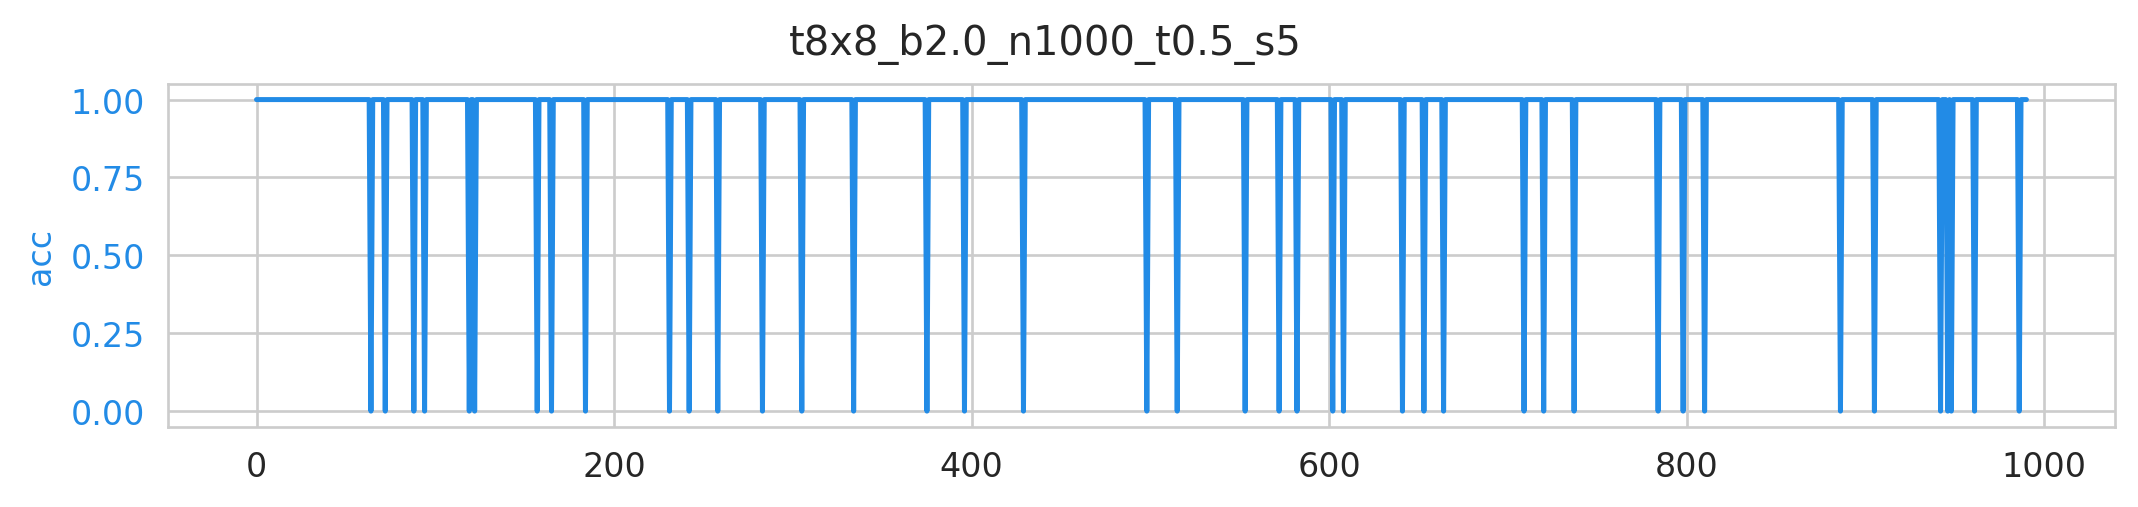

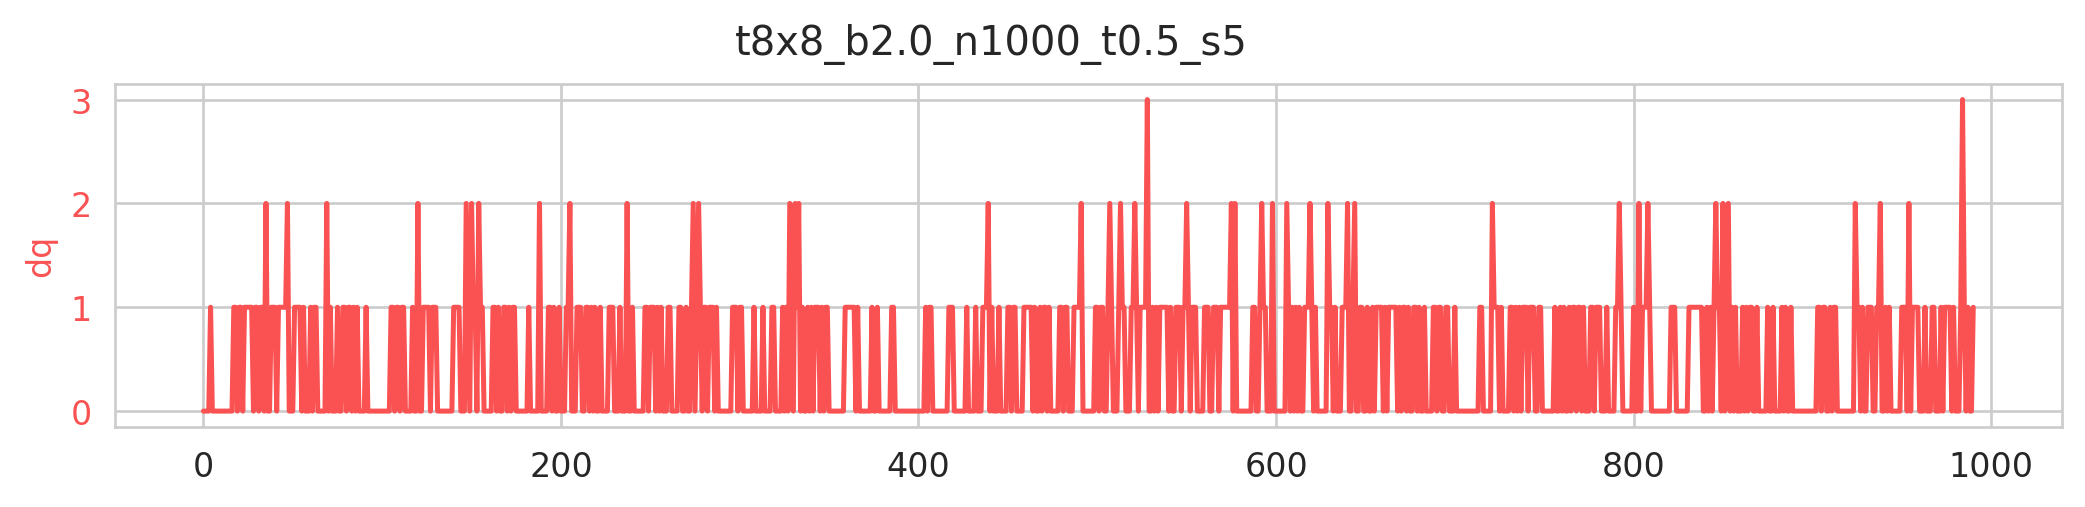

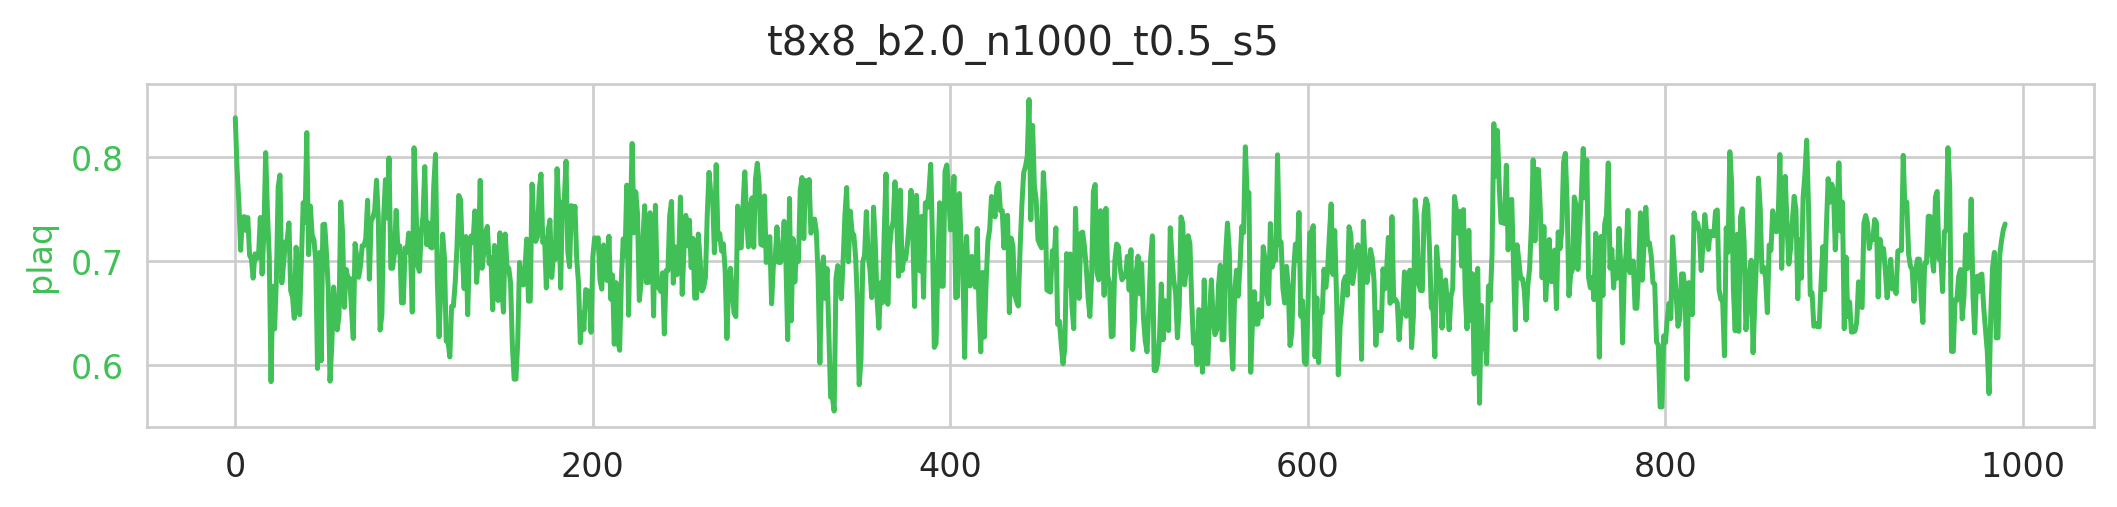

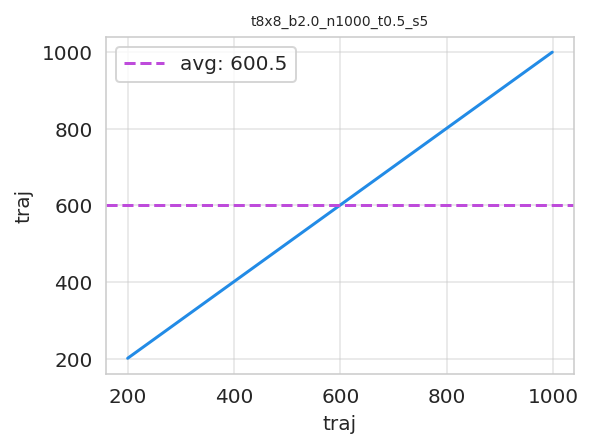

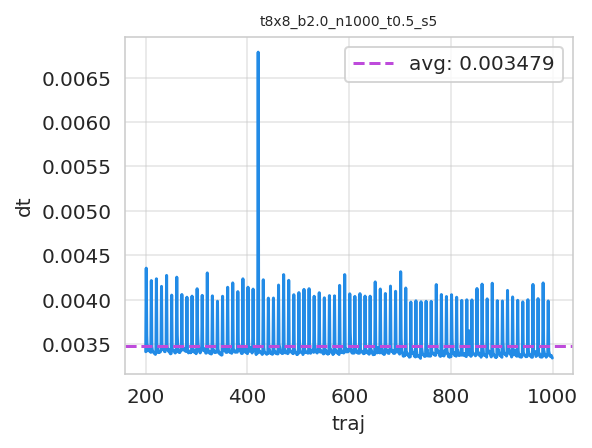

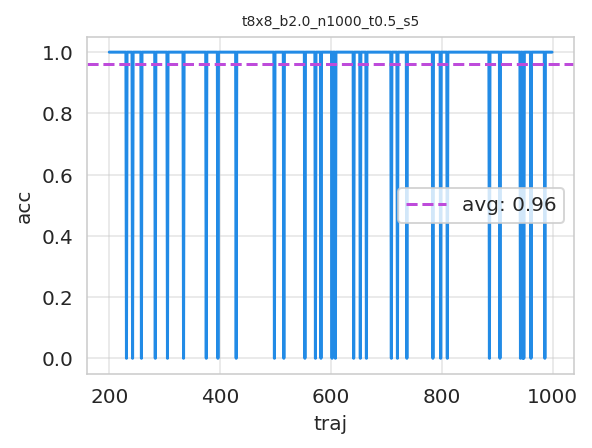

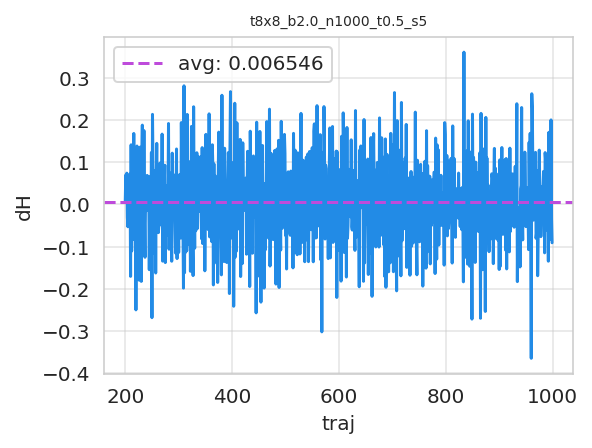

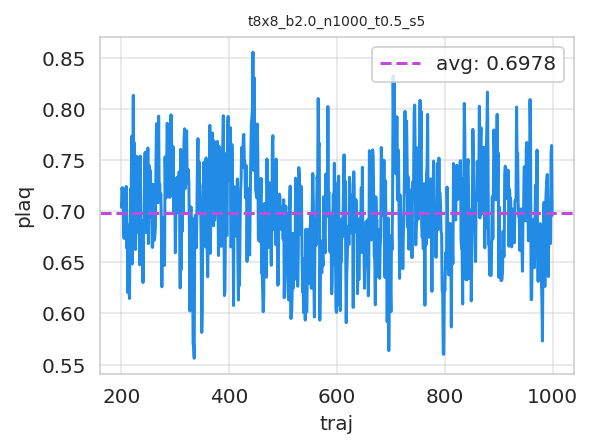

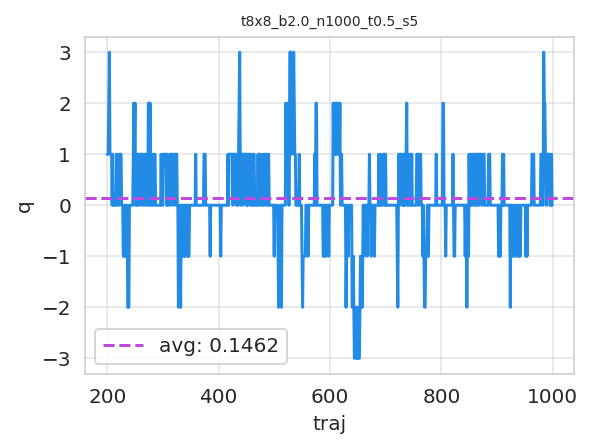

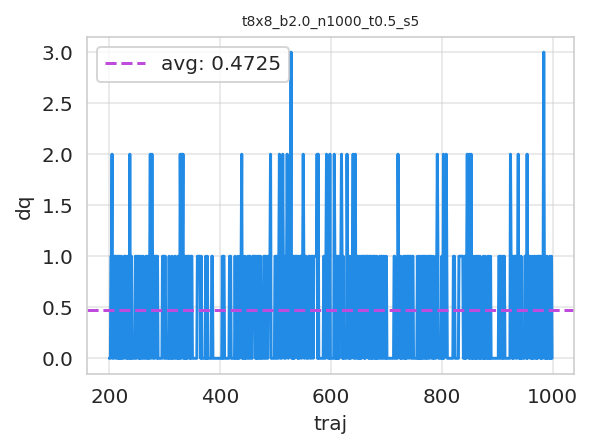

[17:41:24]  Run times: ['61.4226']

            Per trajectory: ['0.0614']

[17:41:24]  Saving hmc_histories to ../../logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n1000_t0.5_s5/202
            1-07-08-174018/hmc_histories.z.

[17:41:24]  Saving hmc_fields_arr to ../../logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n1000_t0.5_s5/20
            21-07-08-174018/hmc_fields_arr.z.

In [8]:
from fthmc.hmc import run_hmc
#plt.style.use('/home/foremans/.matplotlib/stylelib/molokai.mplstyle')

logger.rule(f'Running HMC for {param.nrun} runs, '
            f'of {param.ntraj} trajectories each')
hmc_fields, hmc_history = run_hmc(param, plot_metrics=True, figsize=(9, 2.))

## Train flow model using `TrainConfig` and `SchedulerConfig` defined above

─────────────────────── Training FlowModel for 10 eras and 100 epochs ───────────────────────

[17:41:57]  Creating directory: ../../logs/models/lat8x8/beta2.0/L8_b2.0_nb64_actsilu_nh16_ns
            2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07-08-174157

[17:41:57]  Creating directory: ../../logs/models/lat8x8/beta2.0/L8_b2.0_nb64_actsilu_nh16_ns
            2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07-08-174157/plots

[17:41:57]  Creating directory: ../../logs/models/lat8x8/beta2.0/L8_b2.0_nb64_actsilu_nh16_ns
            2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07-08-174157/checkpoints

[17:41:57]  Creating directory: ../../logs/models/lat8x8/beta2.0/L8_b2.0_nb64_actsilu_nh16_ns
            2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07-08-174157/summaries

[17:41:57]  Writing summaries to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/summaries

            Scheduler created!

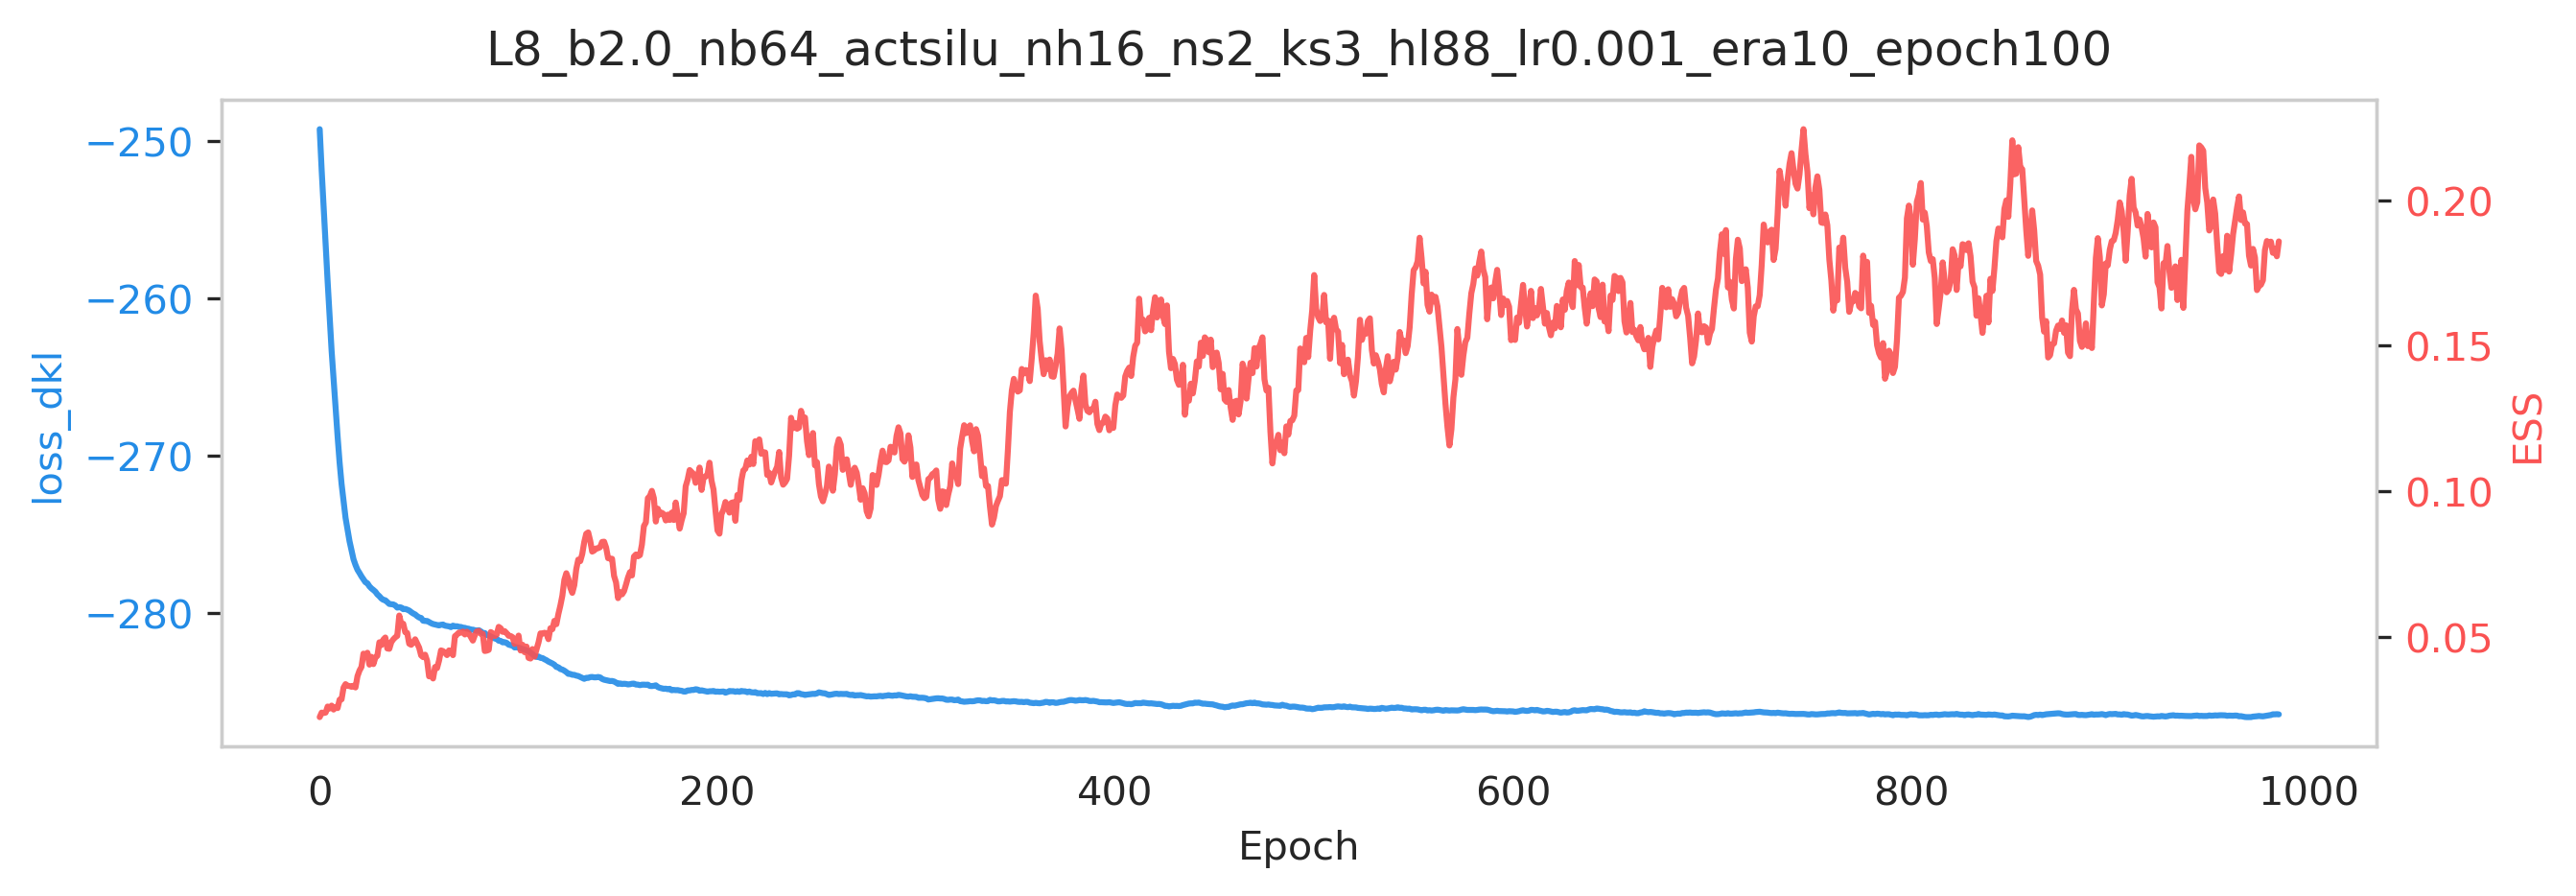

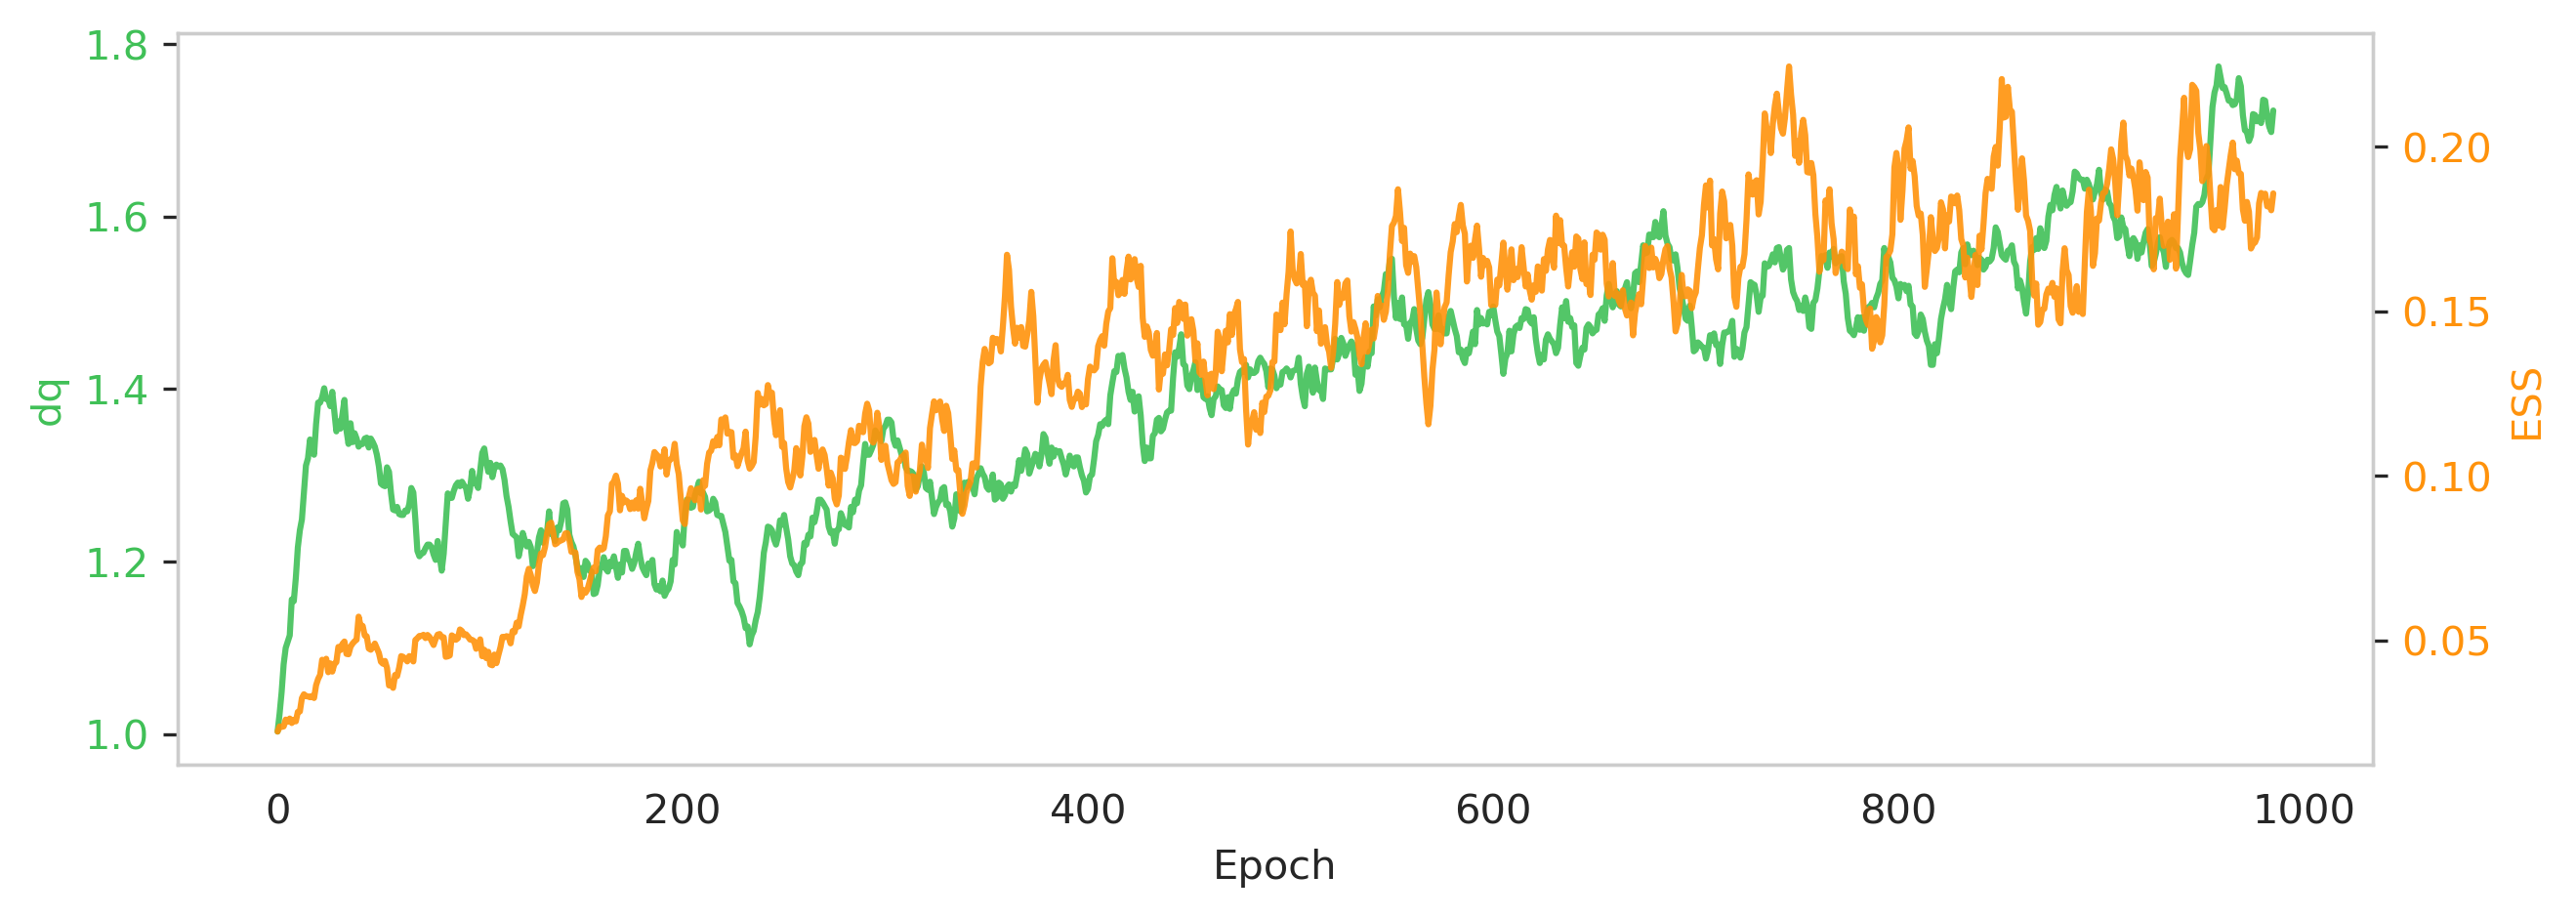

─────────────────────────────── ERA=0, last took: 0 min 0 sec ───────────────────────────────

[17:42:06]  epoch=100 dt=0.084 ess=0.054 logp=74.003 logq=-207.599 loss_dkl=-281.602 dq=1.125
            plaq=0.578

[17:42:07]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/checkpoints/ckpt-era0-epoch99.tar

───────────────────────────── ERA=1, last took: 0 min 9.906 sec ─────────────────────────────

[17:42:16]  epoch=200 dt=0.084 ess=0.181 logp=81.525 logq=-203.343 loss_dkl=-284.867 dq=1.172
            plaq=0.637

[17:42:17]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/checkpoints/ckpt-era1-epoch99.tar

───────────────────────────── ERA=2, last took: 0 min 9.986 sec ─────────────────────────────

[17:42:26]  epoch=300 dt=0.084 ess=0.096 logp=83.386 logq=-201.497 loss_dkl=-284.883 dq=1.516
            plaq=0.651

[17:42:27]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/checkpoints/ckpt-era2-epoch99.tar

───────────────────────────── ERA=3, last took: 0 min 9.942 sec ─────────────────────────────

[17:42:36]  epoch=400 dt=0.084 ess=0.035 logp=84.134 logq=-201.551 loss_dkl=-285.685 dq=1.219
            plaq=0.657

[17:42:37]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/checkpoints/ckpt-era3-epoch99.tar

───────────────────────────── ERA=4, last took: 0 min 10.19 sec ─────────────────────────────

[17:42:47]  epoch=500 dt=0.085 ess=0.101 logp=84.703 logq=-201.603 loss_dkl=-286.307 dq=1.328
            plaq=0.662

[17:42:47]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/checkpoints/ckpt-era4-epoch99.tar

────────────────────────────── ERA=5, last took: 0 min 10 sec ───────────────────────────────

[17:42:57]  epoch=600 dt=0.082 ess=0.167 logp=84.897 logq=-201.309 loss_dkl=-286.206 dq=1.297
            plaq=0.663

[17:42:58]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/checkpoints/ckpt-era5-epoch99.tar

───────────────────────────── ERA=6, last took: 0 min 10.14 sec ─────────────────────────────

[17:43:07]  epoch=700 dt=0.082 ess=0.245 logp=81.789 logq=-204.096 loss_dkl=-285.885 dq=1.344
            plaq=0.639

[17:43:07]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/checkpoints/ckpt-era6-epoch99.tar

───────────────────────────── ERA=7, last took: 0 min 9.779 sec ─────────────────────────────

[17:43:17]  epoch=800 dt=0.082 ess=0.143 logp=86.796 logq=-199.857 loss_dkl=-286.653 dq=1.734
            plaq=0.678

[17:43:17]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/checkpoints/ckpt-era7-epoch99.tar

───────────────────────────── ERA=8, last took: 0 min 9.837 sec ─────────────────────────────

[17:43:26]  epoch=900 dt=0.082 ess=0.064 logp=86.308 logq=-200.312 loss_dkl=-286.619 dq=1.766
            plaq=0.674

[17:43:27]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/checkpoints/ckpt-era8-epoch99.tar

───────────────────────────── ERA=9, last took: 0 min 9.768 sec ─────────────────────────────

[17:43:36]  epoch=1000 dt=0.082 ess=0.196 logp=83.903 logq=-202.597 loss_dkl=-286.500        
            dq=1.797 plaq=0.655

[17:43:37]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/checkpoints/ckpt-era9-epoch99.tar

            Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/checkpoints/ckpt-era10-epoch101.tar

[17:43:37]  Saving live plots to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/202
            1-07-08-174157/plots

[17:43:38]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07
            -08-174157/plots/dt.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07
            -08-174157/plots/ess.png

[17:43:39]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07
            -08-174157/plots/logp.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07
            -08-174157/plots/logq.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07
            -08-174157/plots/loss_dkl.png

[17:43:40]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07
            -08-174157/plots/q.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07
            -08-174157/plots/dq.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07
            -08-174157/plots/plaq.png

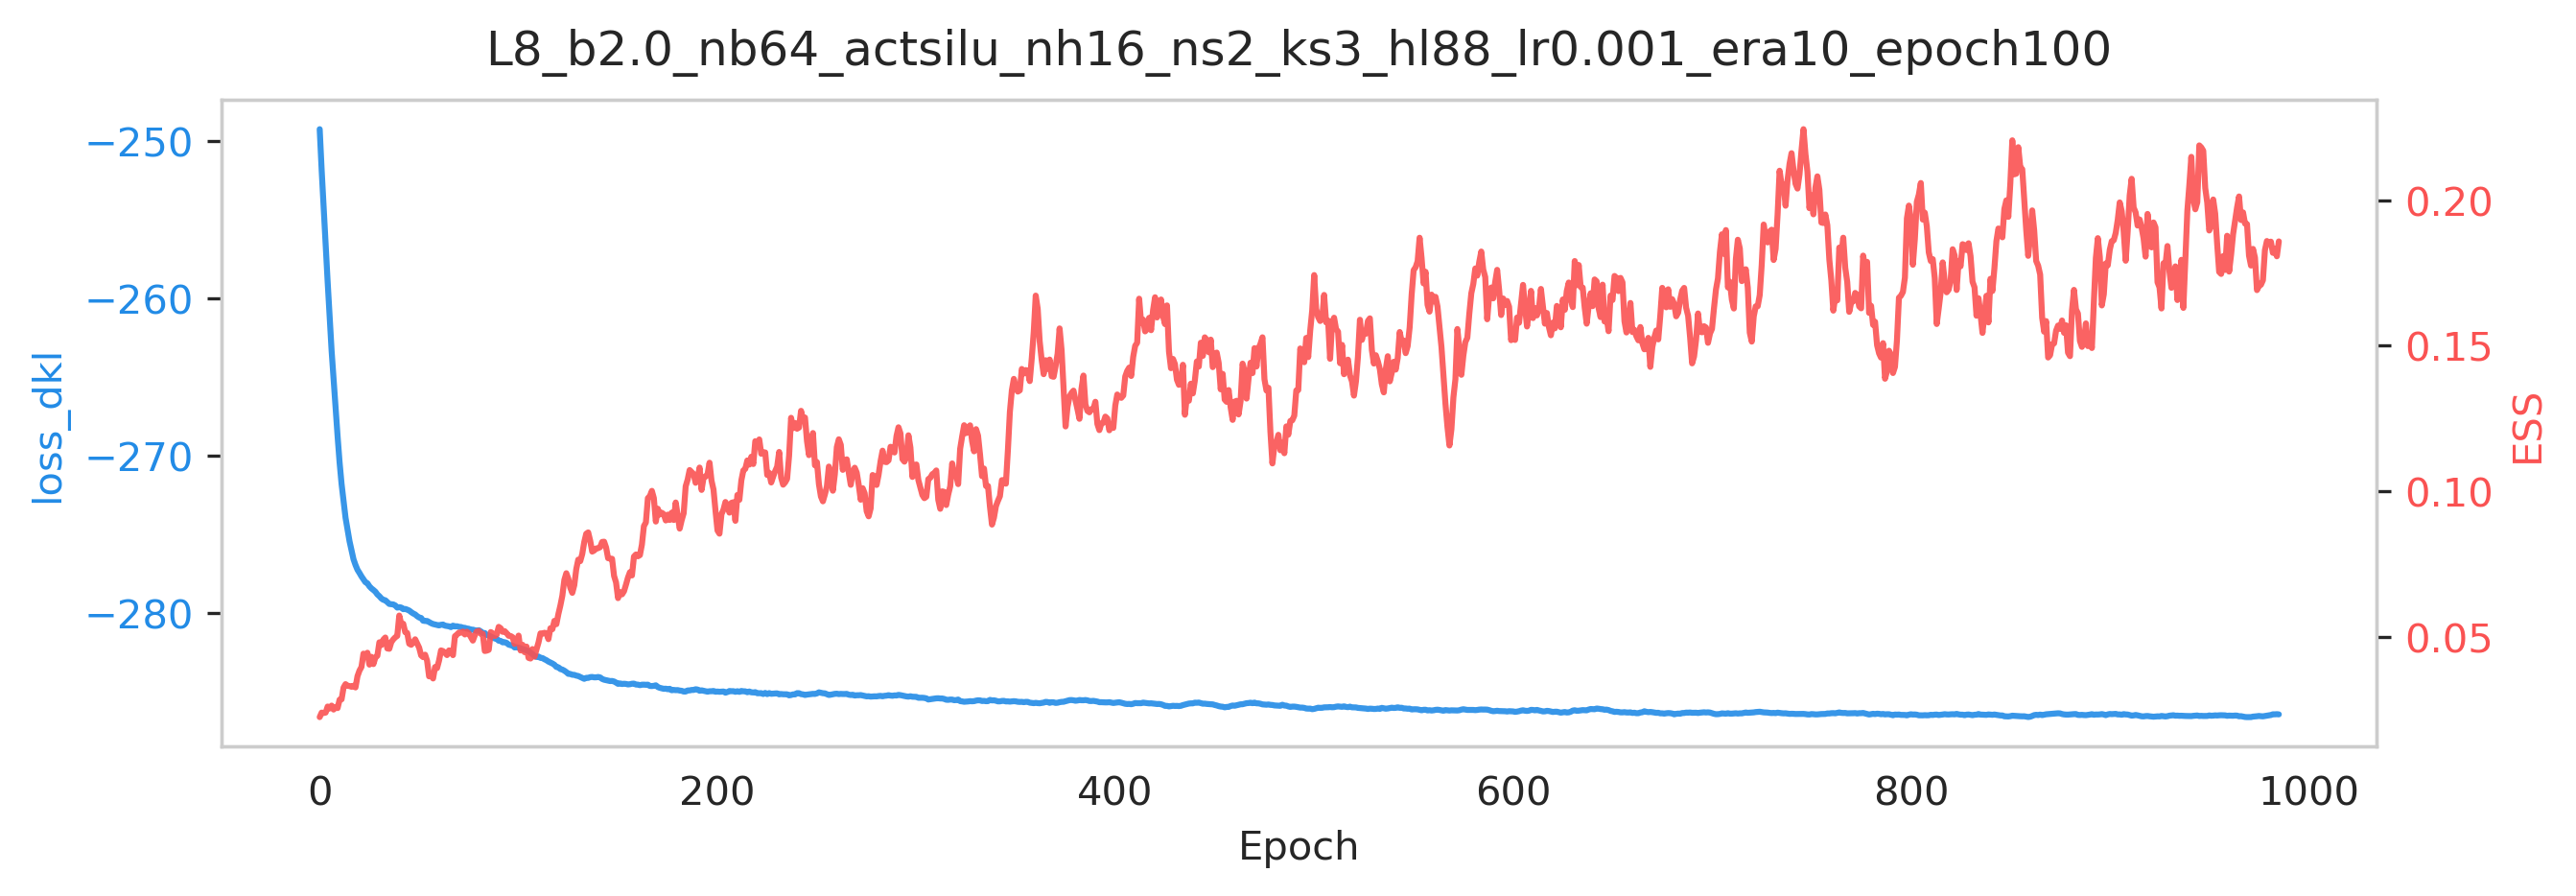

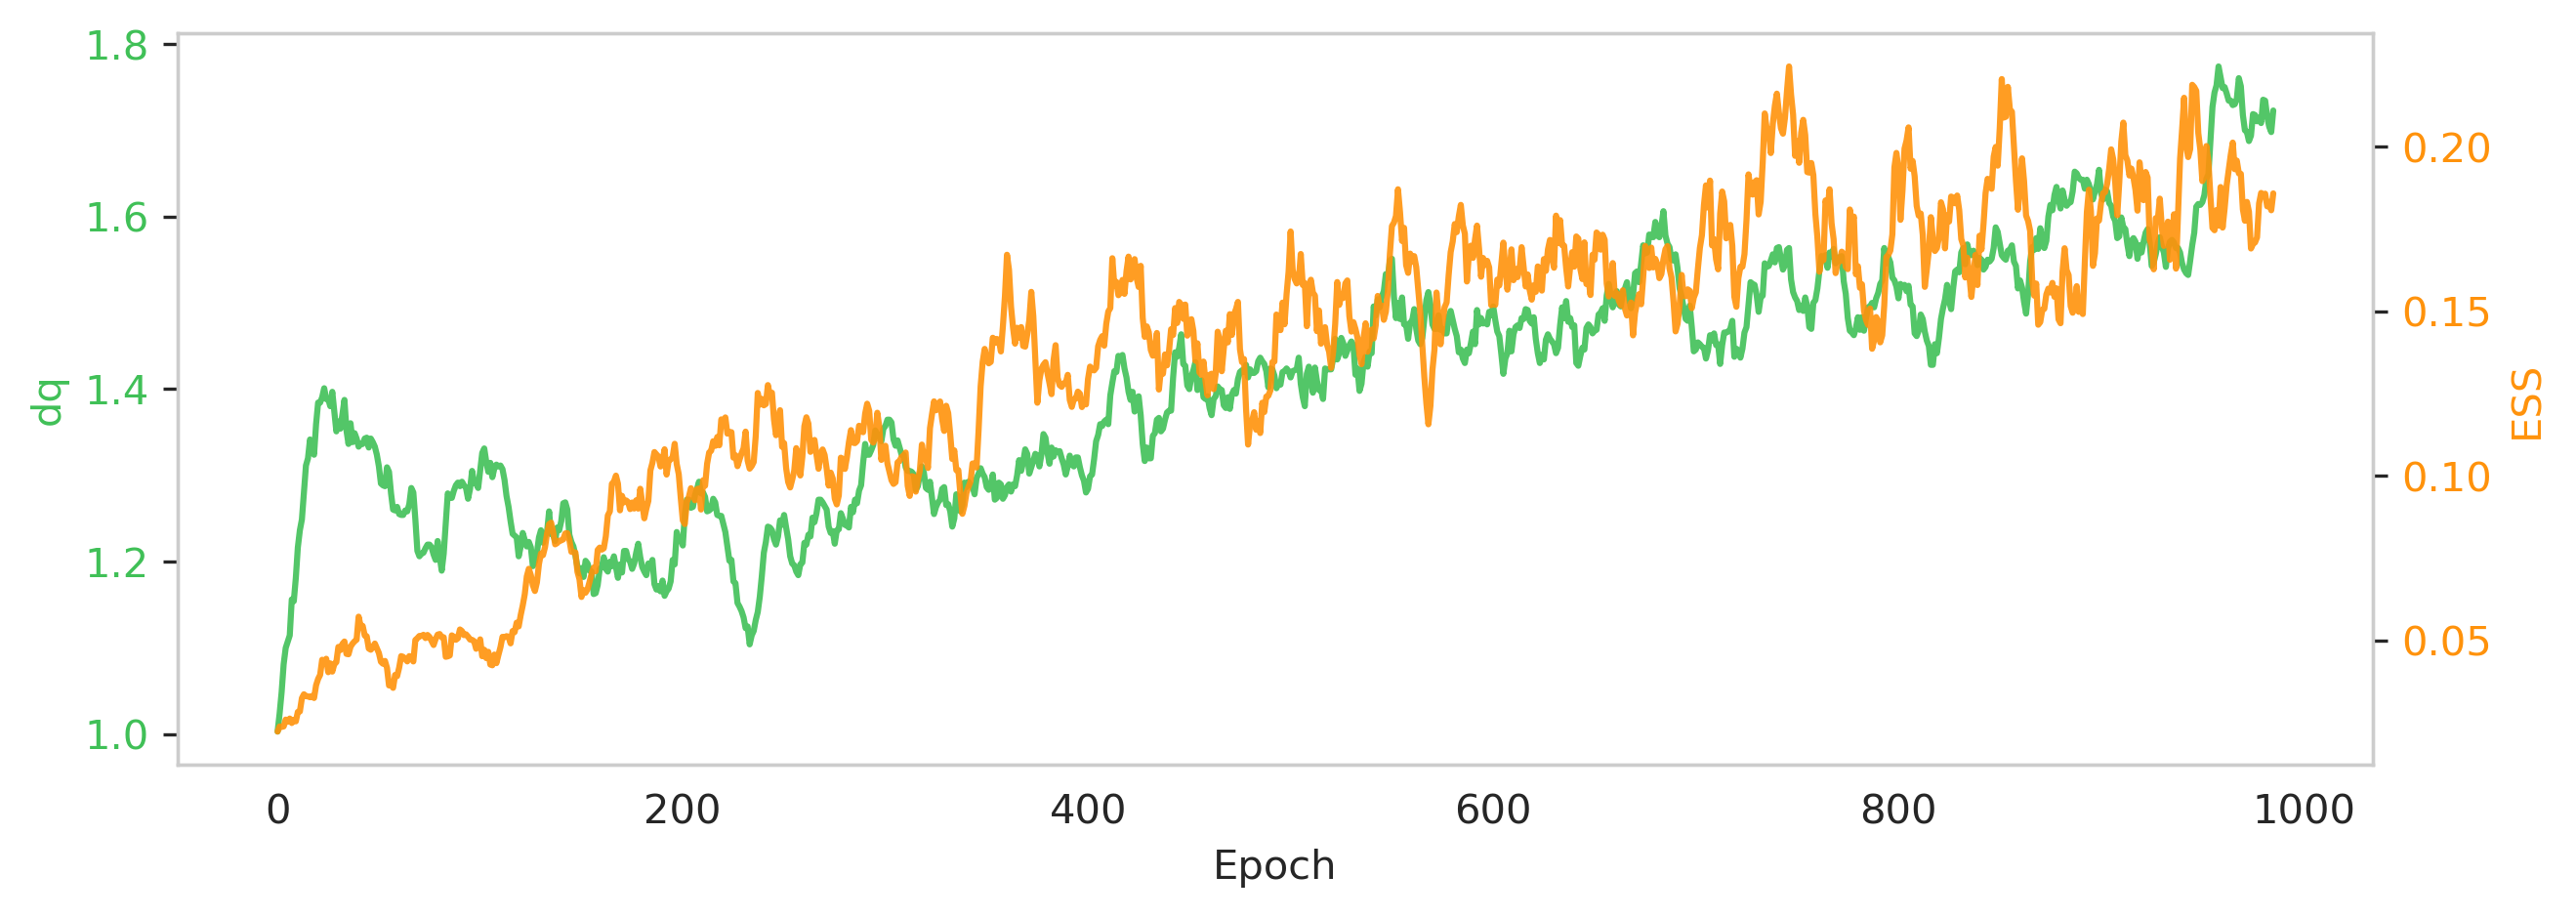

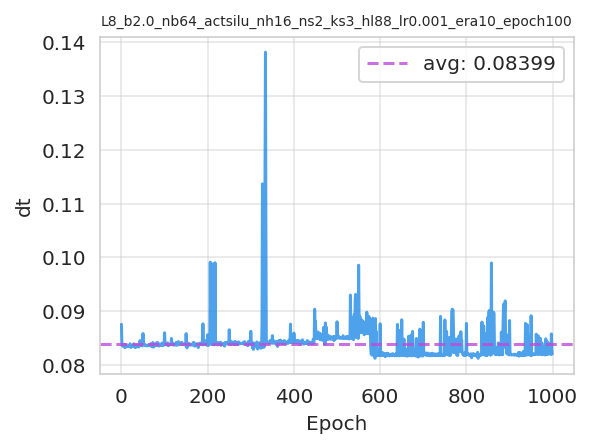

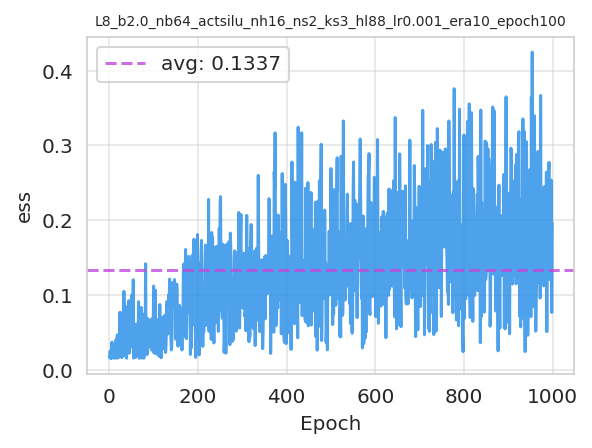

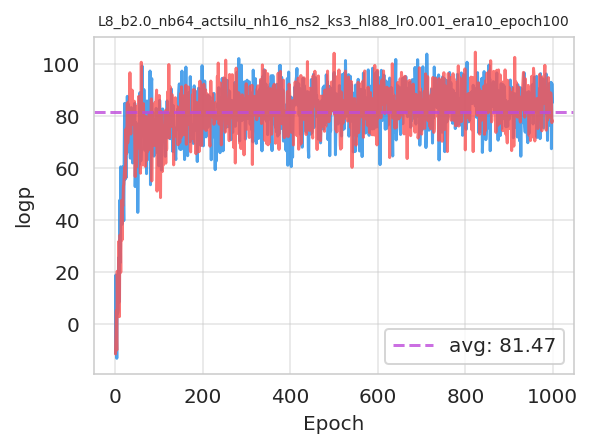

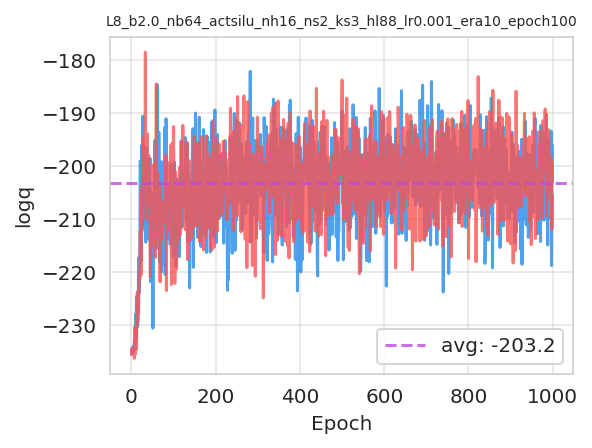

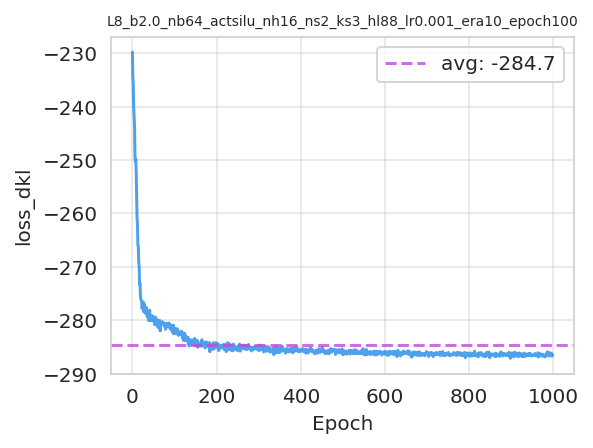

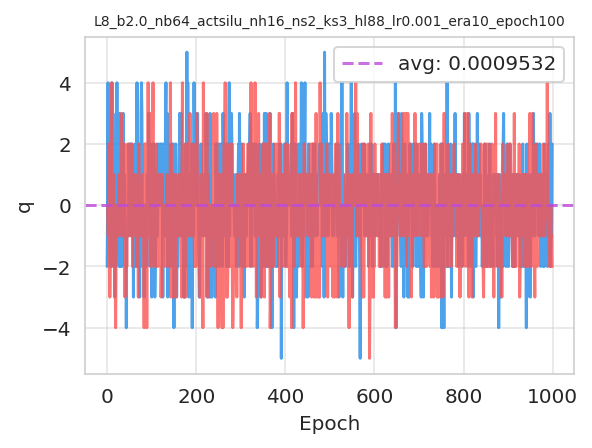

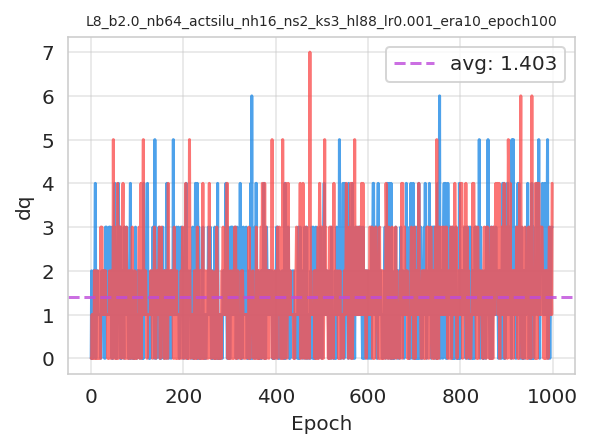

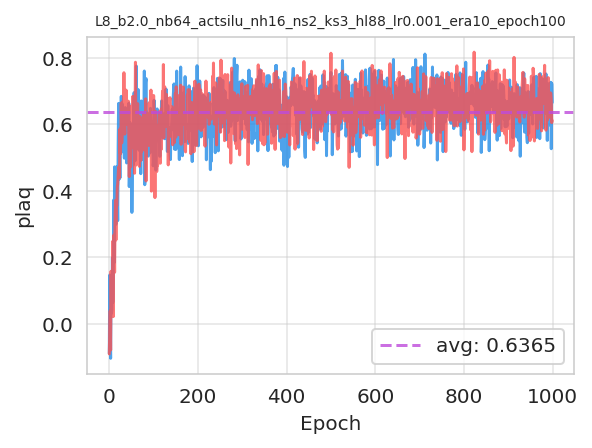

[17:43:42]  Saving train_history to ../../logs/models/lat8x8/beta2.0/L8_b2.0_nb64_actsilu_nh1
            6_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-07-08-174157/train_history.z.

In [9]:
from fthmc.train import train

logger.rule(f'Training FlowModel for {train_config.n_era} '
            f'eras and {train_config.n_epoch} epochs')
train_outputs = train(config=train_config,
                      model=None,  # train_outputs['model'],
                      pre_model=None,  # train_outputs['model'],
                      dpi=150,
                      figsize=(9, 3.),
                      scheduler_config=None)

## Run inference on trained model and evaluate / plot metrics

──────────────────── Running inference on trained model for 8192 samples ────────────────────

/lus/grand/projects/DLHMC/nftqcd/fthmc/fthmc/utils/inference.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val = torch.tensor(val)


[17:52:13]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/plots/
            x.png

[17:52:13]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/be
            ta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/plo
            ts/logq_175213.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/plots/
            logq_175213.png

            Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/be
            ta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/plo
            ts/logp_175213.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/plots/
            logp_175213.png

[17:52:14]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/be
            ta2.0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/plo
            ts/accepted_175214.png

[17:52:14]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/plots/
            accepted_175214.png

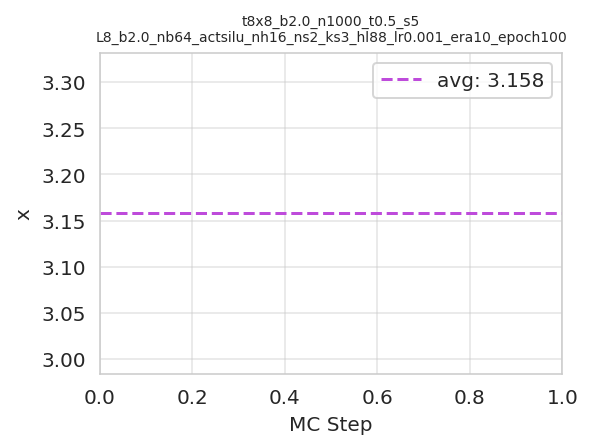

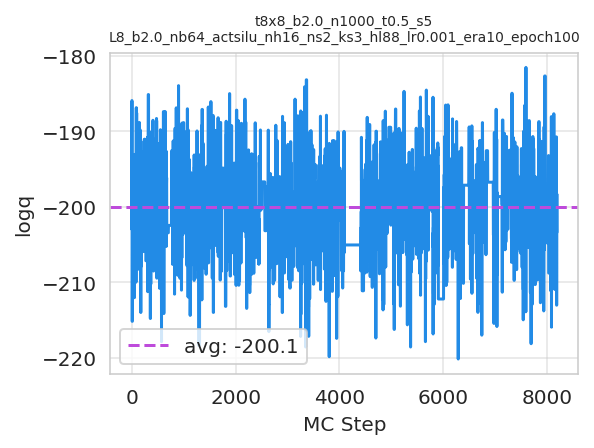

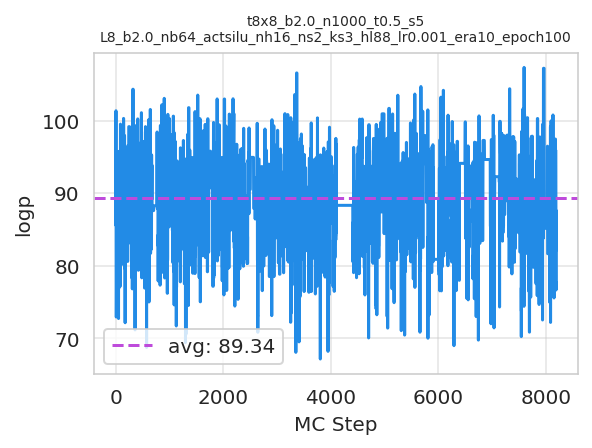

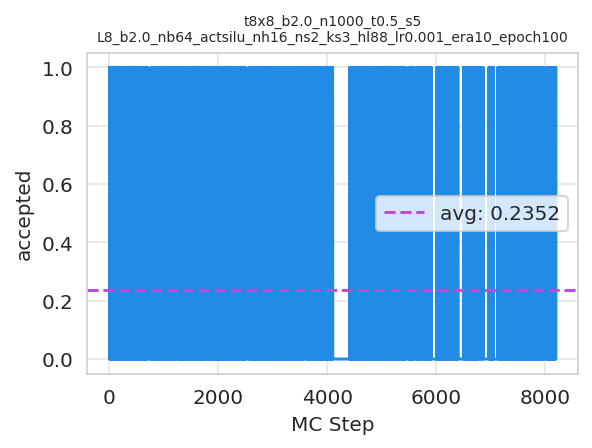

In [17]:
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history
#from fthmc.utils.samplers import make_mcmc_ensemble
from fthmc.utils.inference import U1GaugeAction, make_mcmc_ensemble
from torch.utils.tensorboard import SummaryWriter

NUM_SAMPLES = 8192

logger.rule(f'Running inference on trained model for '
            f'{NUM_SAMPLES} samples')

model = train_outputs['model']
#action_fn = qed.BatchAction(train_config.beta)
action_fn = U1GaugeAction(train_config.beta)
logdir = train_config.logdir

inf_dir = os.path.join(logdir, 'inference')
inf_pdir = os.path.join(inf_dir, 'plots')
inf_sdir = os.path.join(inf_dir, 'summaries')

writer = SummaryWriter(log_dir=inf_sdir)

nb = train_config.batch_size
#model = train_outputs['model']
history = make_mcmc_ensemble(model,
                             #action=action_fn,
                             action_fn,
                             batch_size=nb, 
                             num_samples=NUM_SAMPLES,
                             writer=writer)
                                 #num_samples=NUM_SAMPLES,
                                 #writer=writer)
plot_history(history=history,
             hline=True,
             param=param, config=train_config, #skip=['epoch', 'x'],
             num_chains=4, therm_frac=0., xlabel='MC Step',
             outdir=inf_pdir)

[17:52:58]  slope 1 linear regression S = S_eff + -286.4816

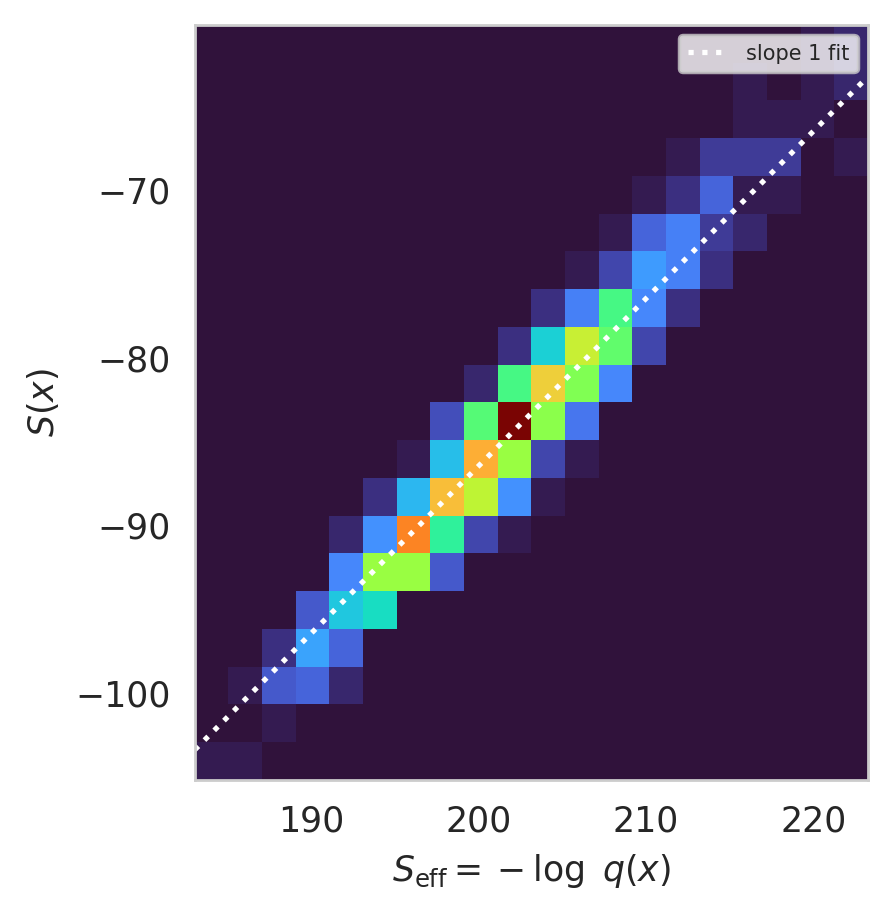

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actsilu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/plots/
            action_linear_regression.pdf

<Figure size 432x288 with 0 Axes>

In [18]:
from fthmc.config import grab
import fthmc.utils.qed_helpers as qed
from fthmc.utils.samplers import apply_flow_to_prior


model = train_outputs['model']
prior = model.prior
layers = model.layers

action = qed.BatchAction(train_config.beta)

x_, xi_, logq_ = apply_flow_to_prior(prior,
                                     layers,
                                     batch_size=1024)
x = grab(x_)
S_eff = -grab(logq_)
S = grab(action(x_))
#S = grab(phi4_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)

logger.log(
    f'slope 1 linear regression S = S_eff + {fit_b:.4f}'
);

S_eff_lims = (np.min(S_eff), np.max(S_eff))
S_lims = (np.min(S), np.max(S))
axrange = [S_eff_lims, S_lims]

fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, cmap='turbo', range=axrange)

          #range=[[150, 195], [-230, -195]]);
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$');
ax.set_ylabel(r'$S(x)$');
ax.set_aspect('equal');
xs = np.linspace(np.min(S_eff), np.max(S_eff),
                 num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':',
        color='w', label='slope 1 fit');
plt.legend(prop={'size': 6});
plt.show();
outfile = os.path.join(inf_pdir,
                       'action_linear_regression.pdf')
logger.log(f'Saving figure to: {outfile}')
plt.savefig(outfile, dpi=250, bbox_inches='tight');

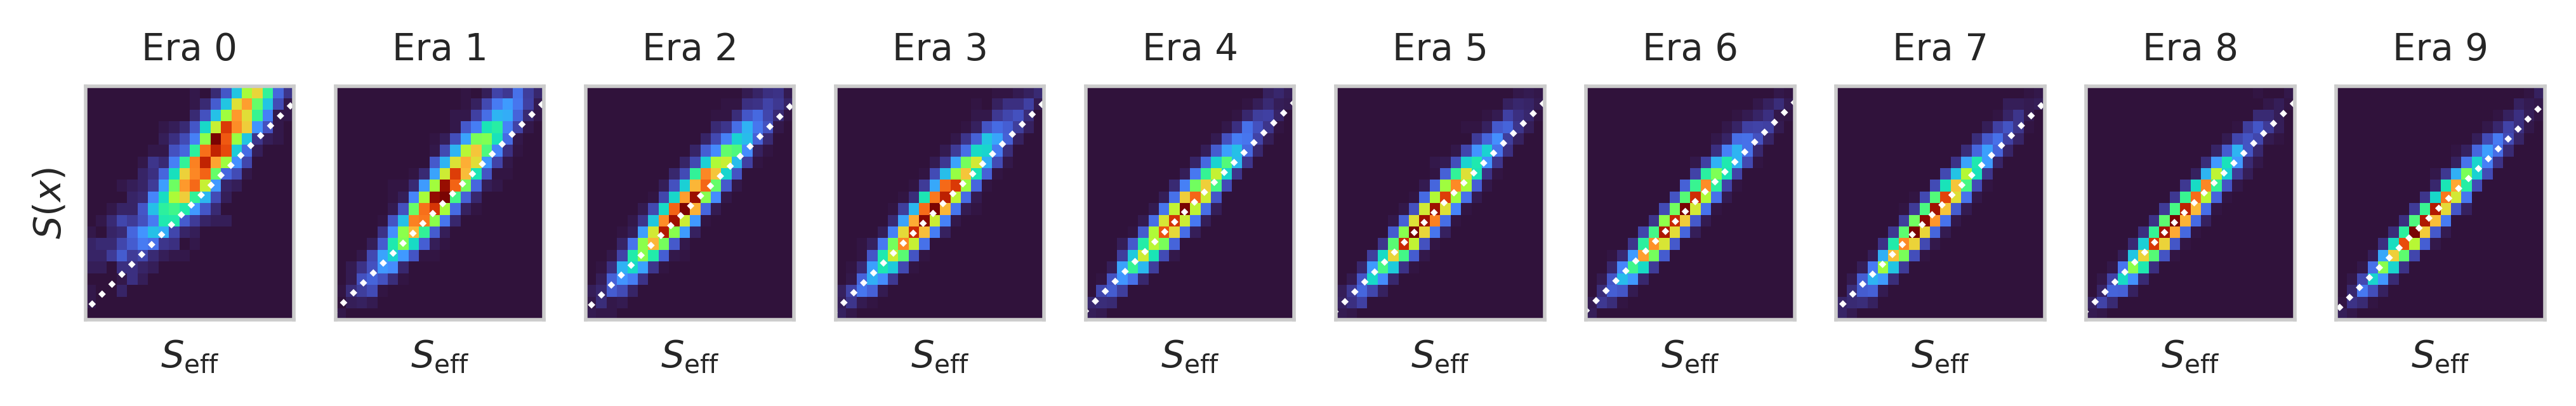

In [22]:
history = train_outputs['history']
n_era = train_config.n_era

fig, axes = plt.subplots(1, 10, dpi=250, sharey=True, figsize=(10, 1))
                         #constrained_layout=True)

logq_hist = np.array(history['logq']).reshape(n_era, -1)[::n_era//10]
logp_hist = np.array(history['logp']).reshape(n_era, -1)[::n_era//10]

for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
    ax.hist2d(-logq, -logp, bins=20, range=axrange, cmap='turbo');
    xs = np.linspace(np.min(-logq), np.max(-logq),
                     num=4, endpoint=True)
    ax.plot(xs, xs + fit_b, ':', lw=1.2,
            color='w', label='slope 1 fit');
    if i == 0:
        ax.set_ylabel(r'$S(x)$', fontsize='small');
    ax.set_xlabel(r'$S_{\mathrm{eff}}$', fontsize='small');
    ax.set_title(f'Era {i * (n_era//10)}', fontsize='small');
    ax.set_xticks([]);
    ax.set_yticks([]);
    #ax.legend(prop={'size': 6});
    ax.set_aspect('equal');
plt.show();

## Run `FieldTransformation` HMC with trained model

In [23]:
import time
import torch.nn as nn

from fthmc.utils.plot_helpers import init_live_plot, update_plot
from math import pi as PI

TWO_PI = 2. * PI

In [24]:
from dataclasses import asdict
from fthmc.utils.plot_helpers import update_plot
from fthmc.field_transformation import FieldTransformation
from fthmc.config import ftConfig

tau = param.tau
nstep = param.nstep

ftconfig = ftConfig(tau=tau, nstep=nstep)

flow = train_outputs['model'].layers
    
if torch.cuda.is_available():
    flow.to('cuda')
    
flow.eval()
#pdict = asdict(param)
#pdict['tau'] = 0.1
#pdict['nstep'] = 5


field_transformation = FieldTransformation(flow=flow, config=train_config, ftconfig=ftconfig)

ModuleList(
  (0): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): SiLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): SiLU()
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (1): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): SiLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): SiLU()
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (2): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLaye

ModuleList(
  (0): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): SiLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): SiLU()
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (1): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): SiLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): SiLU()
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (2): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLaye

[17:58:45]  plaq=0.386 q=0.000

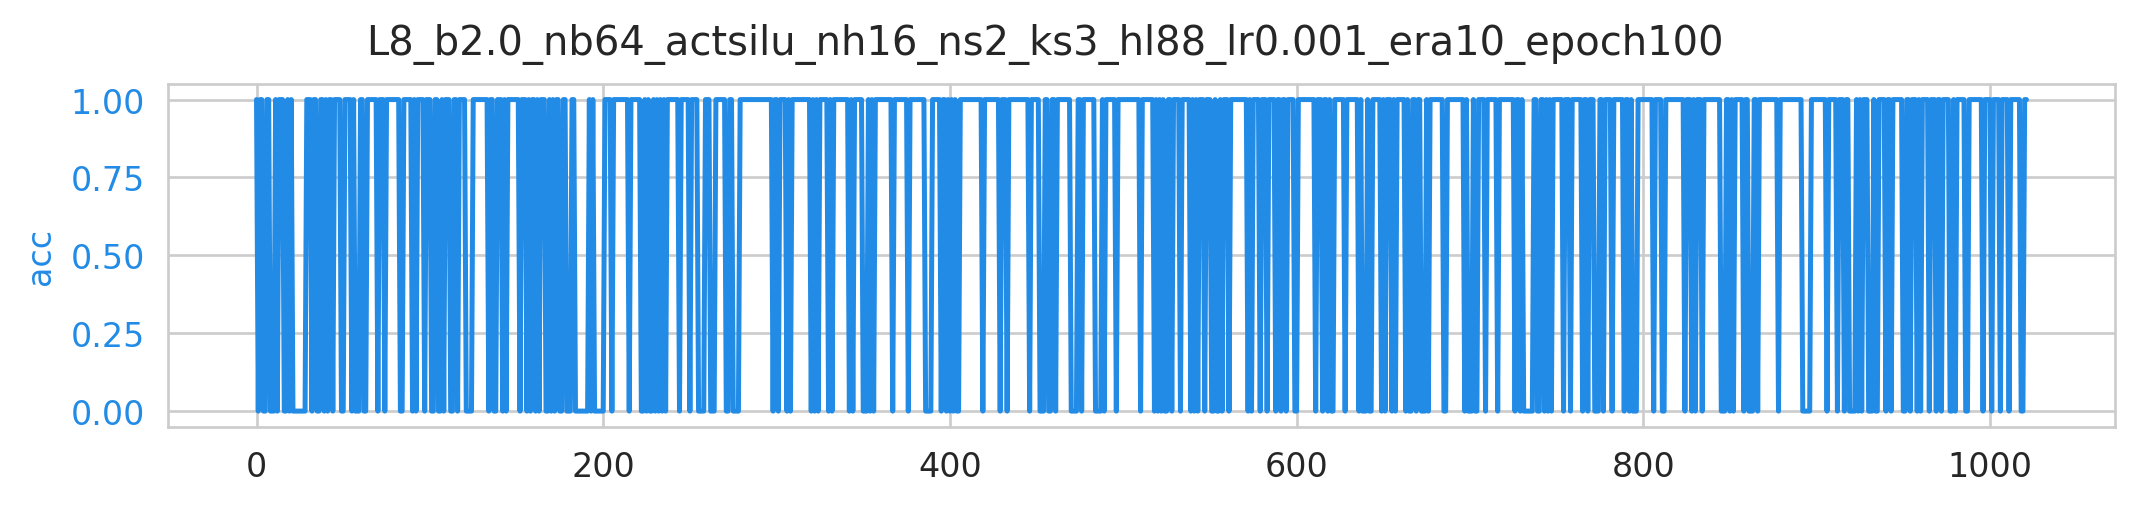

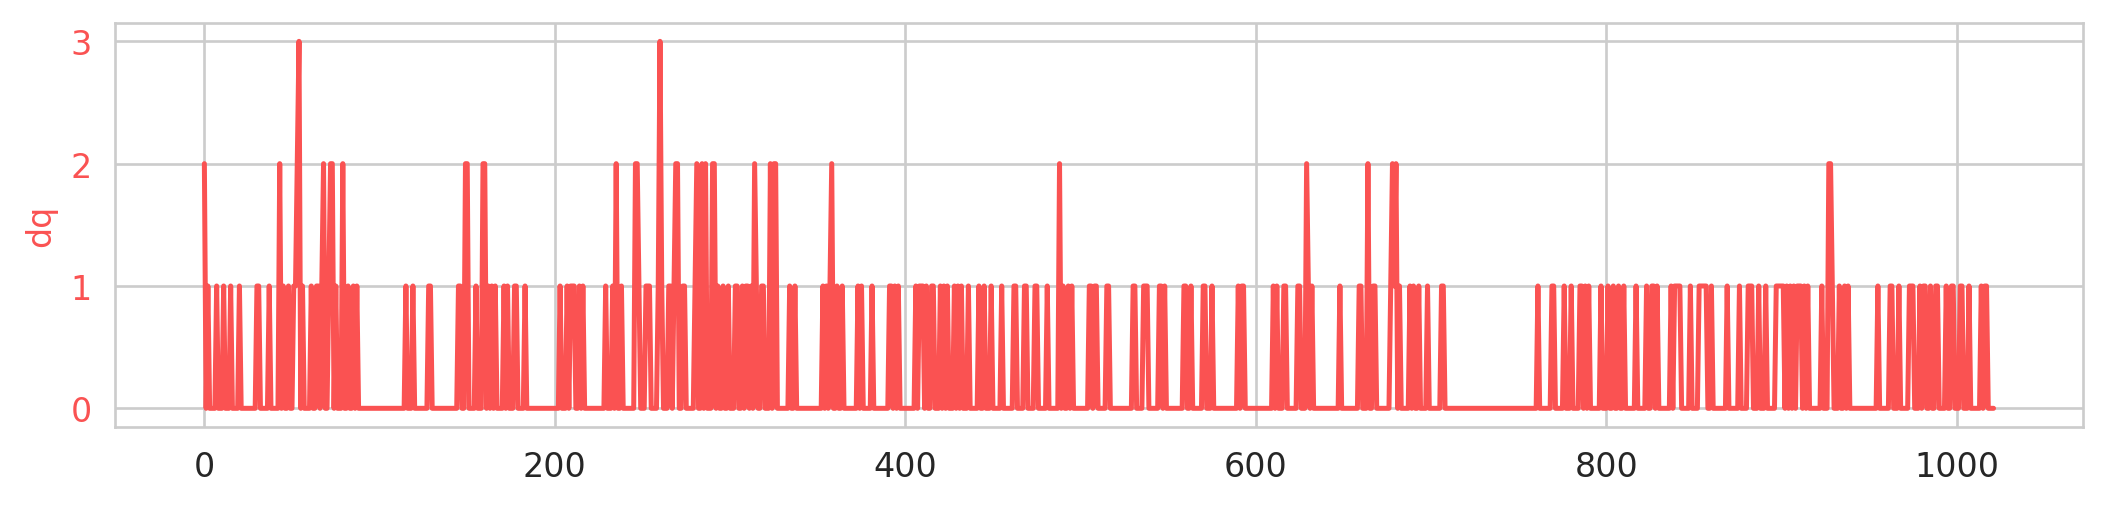

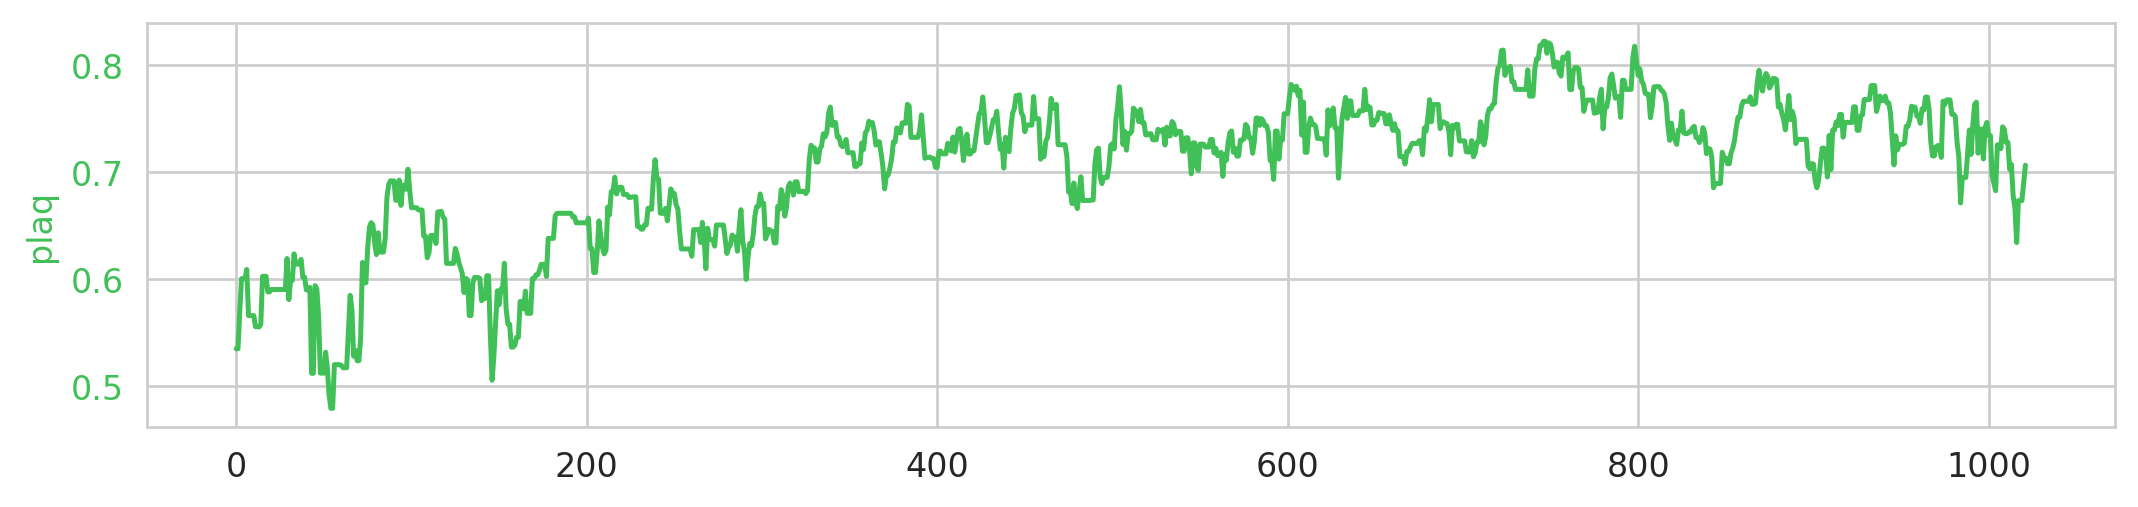

/lus/grand/projects/DLHMC/nftqcd/fthmc/fthmc/field_transformation.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val = torch.tensor(val, dtype=DTYPE)


[17:58:46]  traj=0 dt=0.470 acc=1.000 dh=-1.512 plaq=0.535 q=-2.000 dq=2.000

[17:59:10]  traj=50 dt=0.396 acc=0.000 dh=0.978 plaq=0.512 q=0.000 dq=0.000

[17:59:35]  traj=100 dt=0.396 acc=1.000 dh=-0.870 plaq=0.667 q=-1.000 dq=0.000

[17:59:59]  traj=150 dt=0.396 acc=1.000 dh=0.492 plaq=0.576 q=-1.000 dq=2.000

[18:00:24]  traj=200 dt=0.398 acc=0.000 dh=2.094 plaq=0.653 q=0.000 dq=0.000

[18:00:49]  traj=250 dt=0.406 acc=0.000 dh=4.375 plaq=0.680 q=-1.000 dq=0.000

[18:01:14]  traj=300 dt=0.400 acc=1.000 dh=1.019 plaq=0.671 q=-0.000 dq=0.000

[18:01:39]  traj=350 dt=0.404 acc=0.000 dh=0.793 plaq=0.718 q=-1.000 dq=0.000

[18:02:04]  traj=400 dt=0.399 acc=0.000 dh=0.392 plaq=0.704 q=-3.000 dq=0.000

[18:02:28]  traj=450 dt=0.399 acc=1.000 dh=0.146 plaq=0.738 q=0.000 dq=0.000

[18:02:53]  traj=500 dt=0.405 acc=1.000 dh=-0.089 plaq=0.727 q=-1.000 dq=0.000

[18:03:18]  traj=550 dt=0.408 acc=1.000 dh=-0.284 plaq=0.726 q=1.000 dq=0.000

[18:03:43]  traj=600 dt=0.407 acc=0.000 dh=0.446 plaq=0.755 q=-0.000 dq=0.000

[18:04:08]  traj=650 dt=0.400 acc=1.000 dh=0.206 plaq=0.749 q=-1.000 dq=0.000

[18:04:34]  traj=700 dt=0.406 acc=0.000 dh=1.875 plaq=0.729 q=0.000 dq=0.000

[18:04:59]  traj=750 dt=0.401 acc=1.000 dh=0.096 plaq=0.820 q=0.000 dq=0.000

[18:05:24]  traj=800 dt=0.409 acc=1.000 dh=0.805 plaq=0.791 q=0.000 dq=0.000

[18:05:50]  traj=850 dt=0.405 acc=0.000 dh=0.642 plaq=0.713 q=-1.000 dq=0.000

[18:06:15]  traj=900 dt=0.403 acc=1.000 dh=1.201 plaq=0.708 q=-2.000 dq=1.000

[18:06:40]  traj=950 dt=0.405 acc=0.000 dh=0.652 plaq=0.726 q=-2.000 dq=0.000

[18:07:05]  traj=1000 dt=0.402 acc=1.000 dh=-0.642 plaq=0.734 q=0.000 dq=0.000

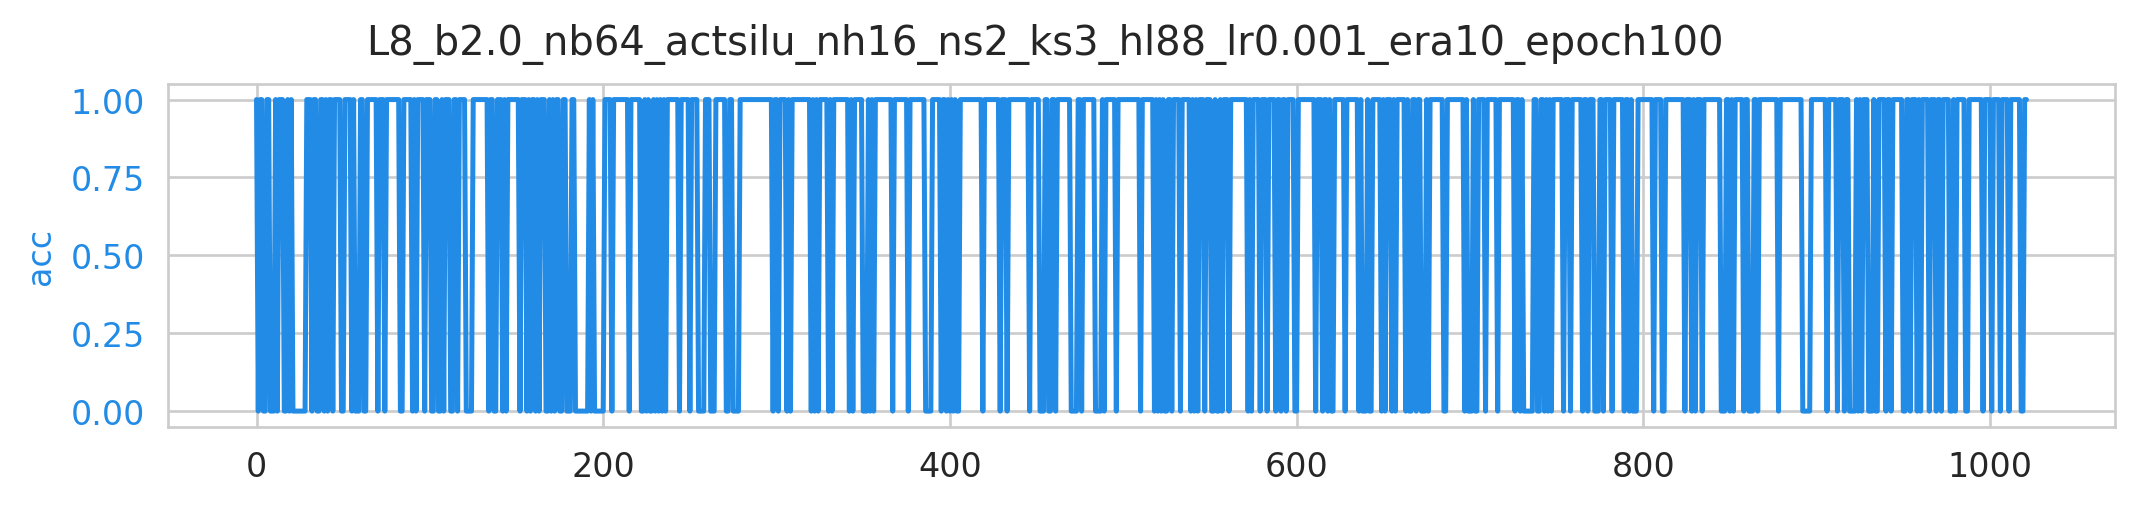

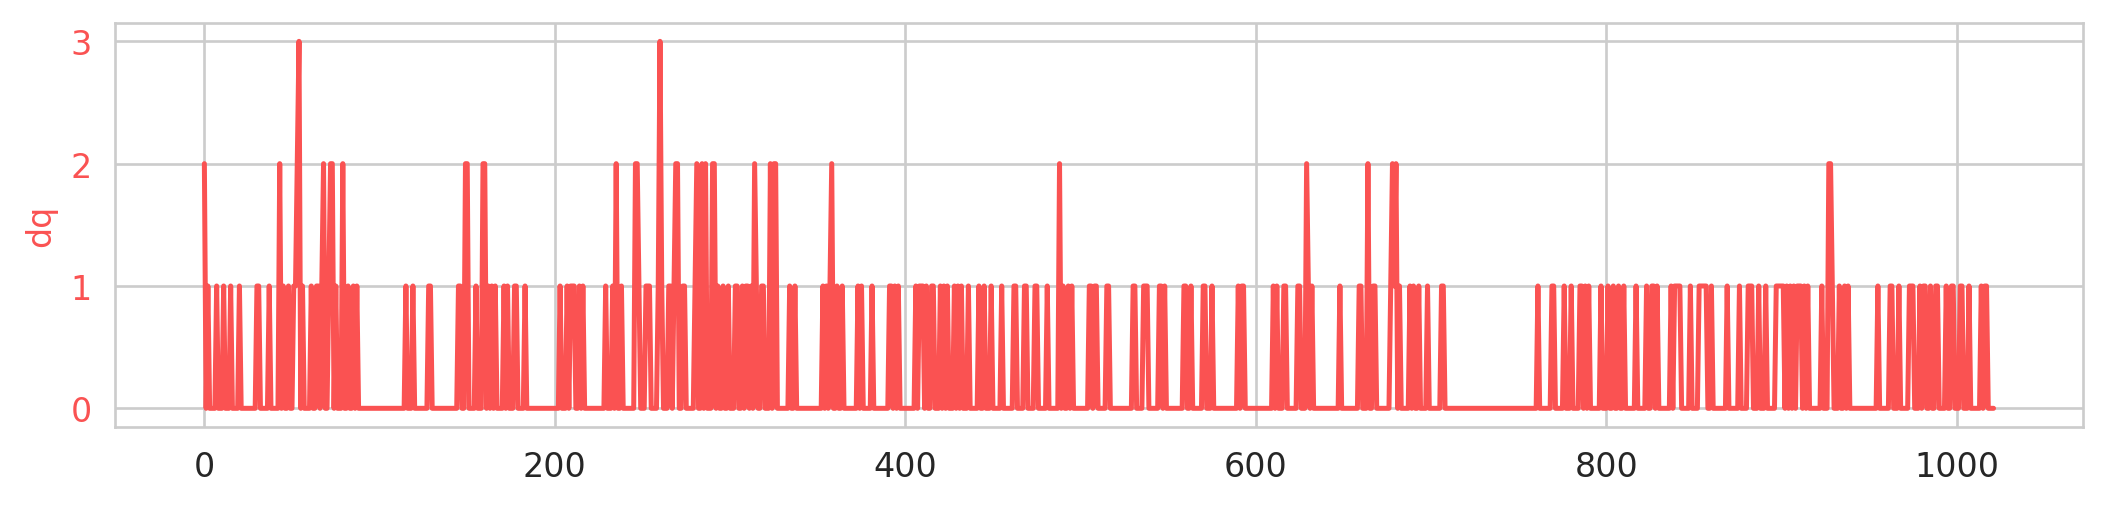

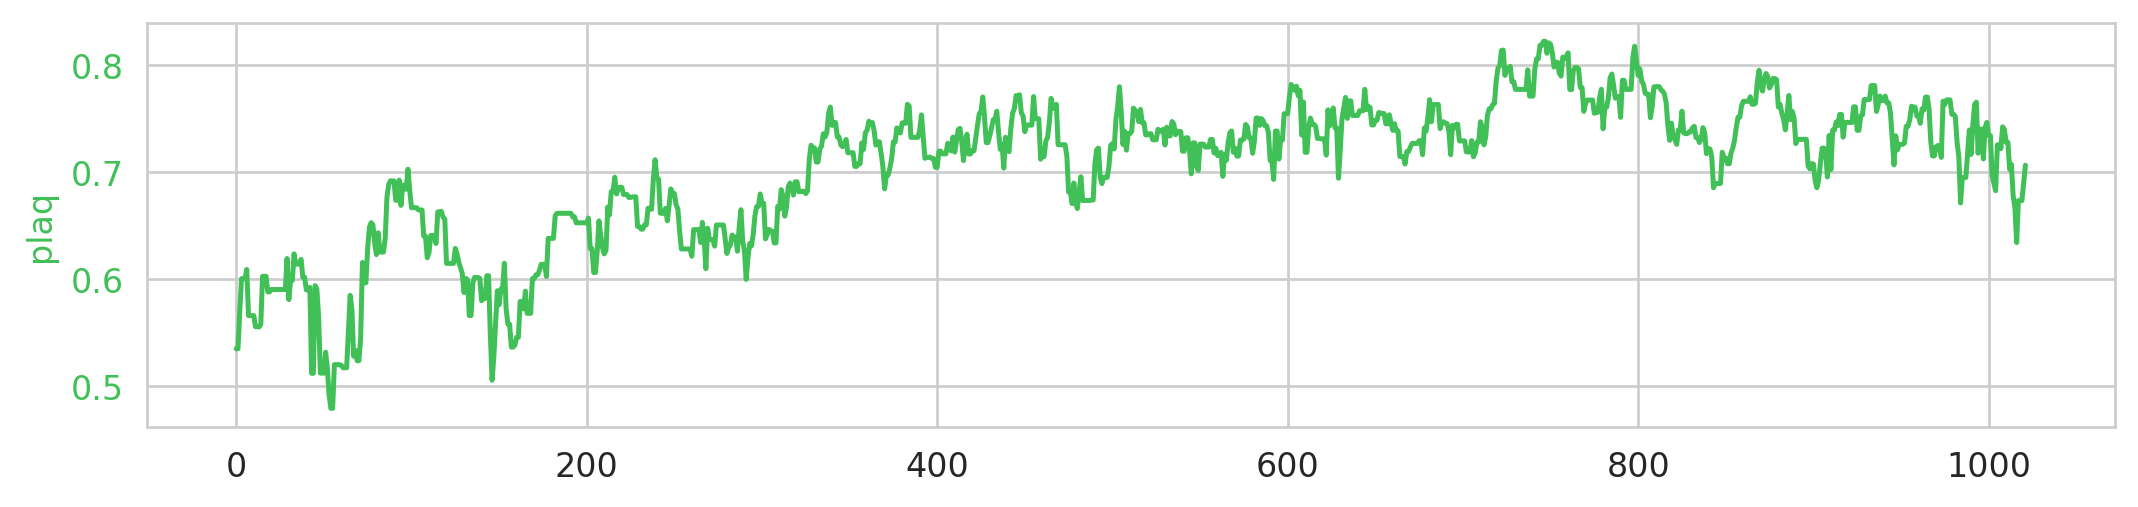

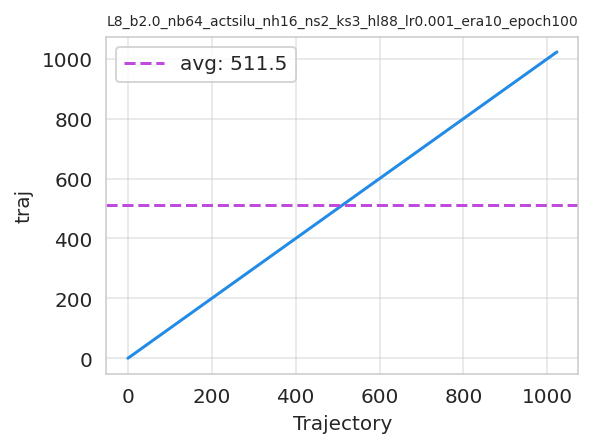

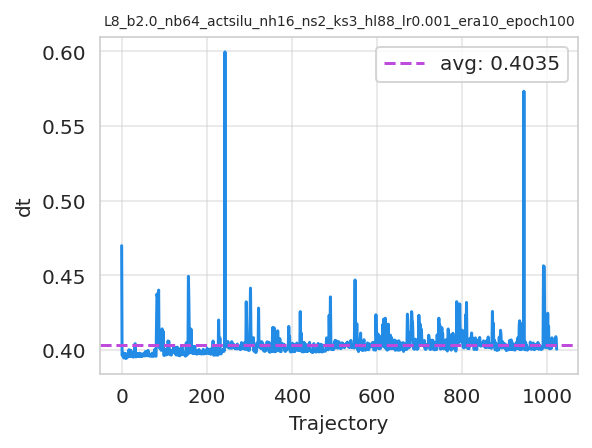

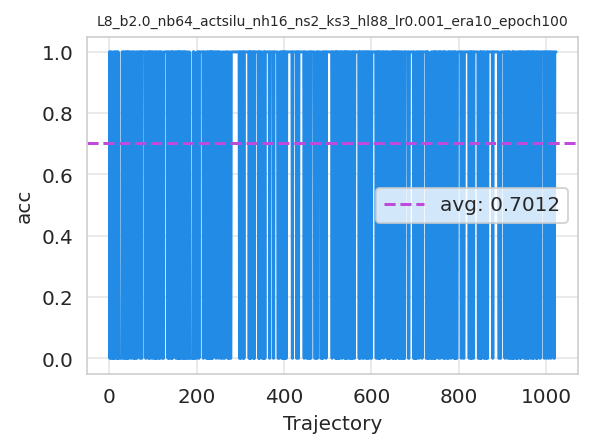

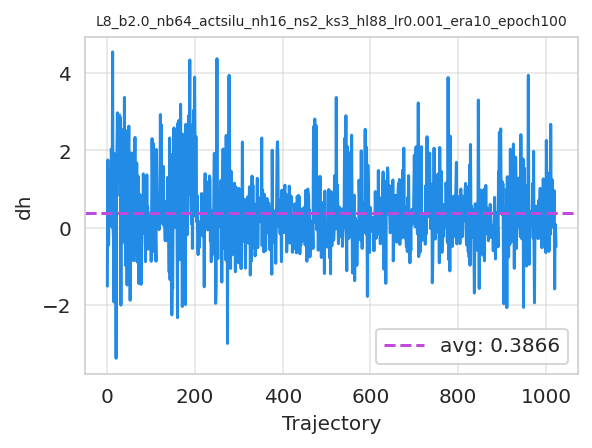

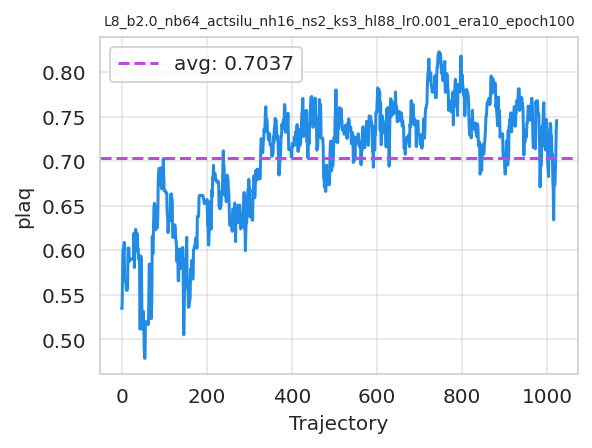

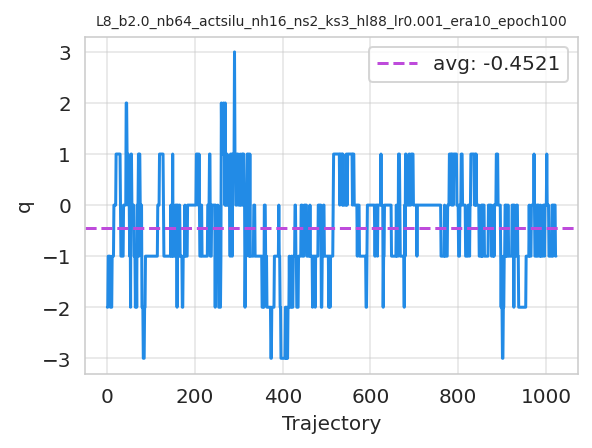

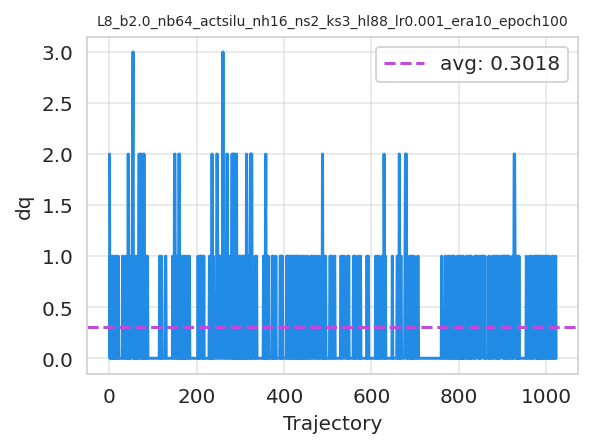

In [25]:
#x_ = hmc_fields[-1][-1].cuda()

logdir = train_config.logdir

ftstr = ftconfig.uniquestr()
fthmcdir = os.path.join(logdir, 'ftHMC', ftstr)

pdir = os.path.join(fthmcdir, 'plots')
sdir = os.path.join(fthmcdir, 'summaries')

writer = SummaryWriter(log_dir=sdir)

runs_history = field_transformation.run(nprint=50,
                                        #x=x_,
                                        figsize=(9., 2.),
                                        num_trajs=1024,
                                        writer=writer,
                                        dpi=120, nplot=10, window=1)

## Try adjusting $\tau$ and $N_{\mathrm{LF}}$ in `ftHMC`

ModuleList(
  (0): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): SiLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): SiLU()
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (1): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): SiLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): SiLU()
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (2): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLaye

ModuleList(
  (0): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): SiLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): SiLU()
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (1): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): SiLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): SiLU()
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (2): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLaye

─────────────────────────── Running `ftHMC` w/ tau=0.05, nstep=2 ────────────────────────────

[18:36:29]  plaq=0.408 q=-1.000

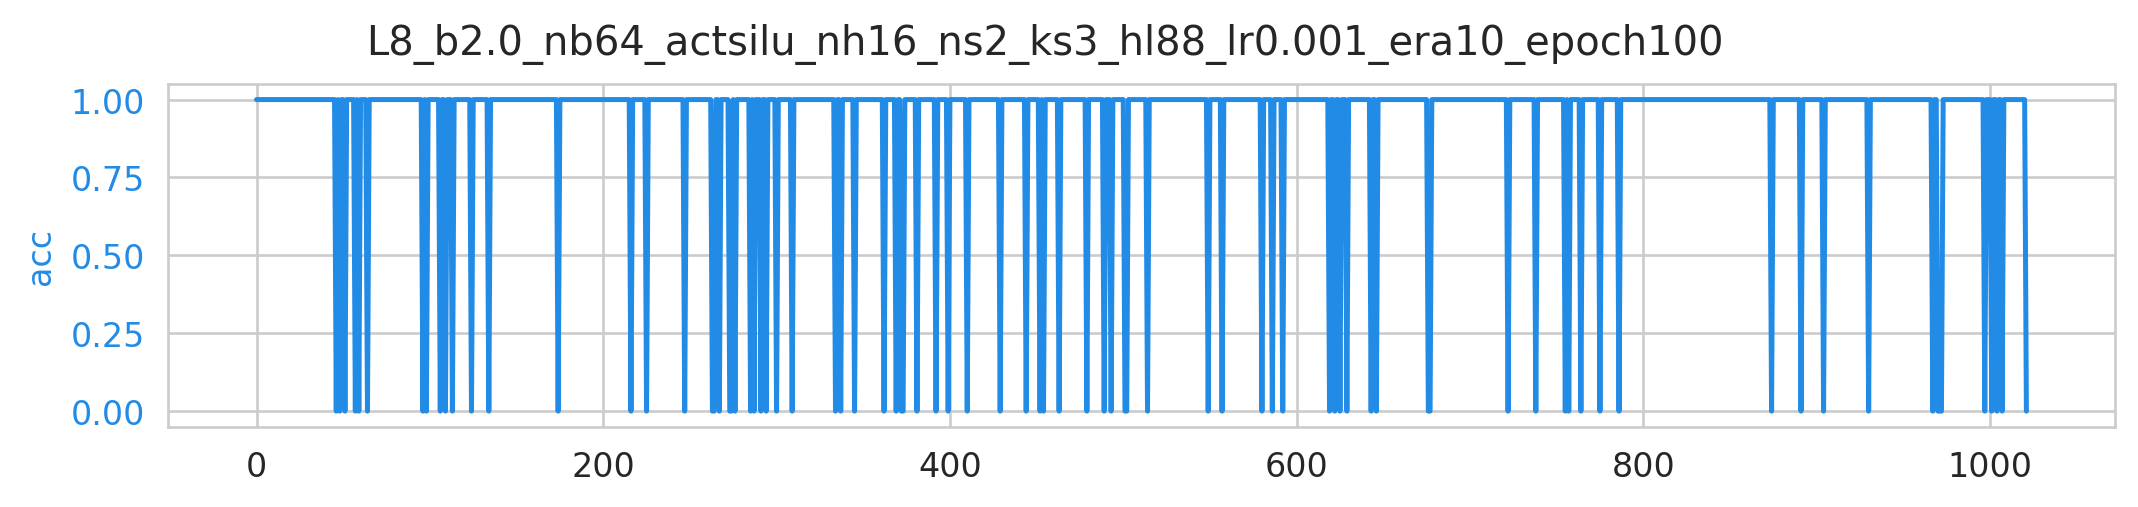

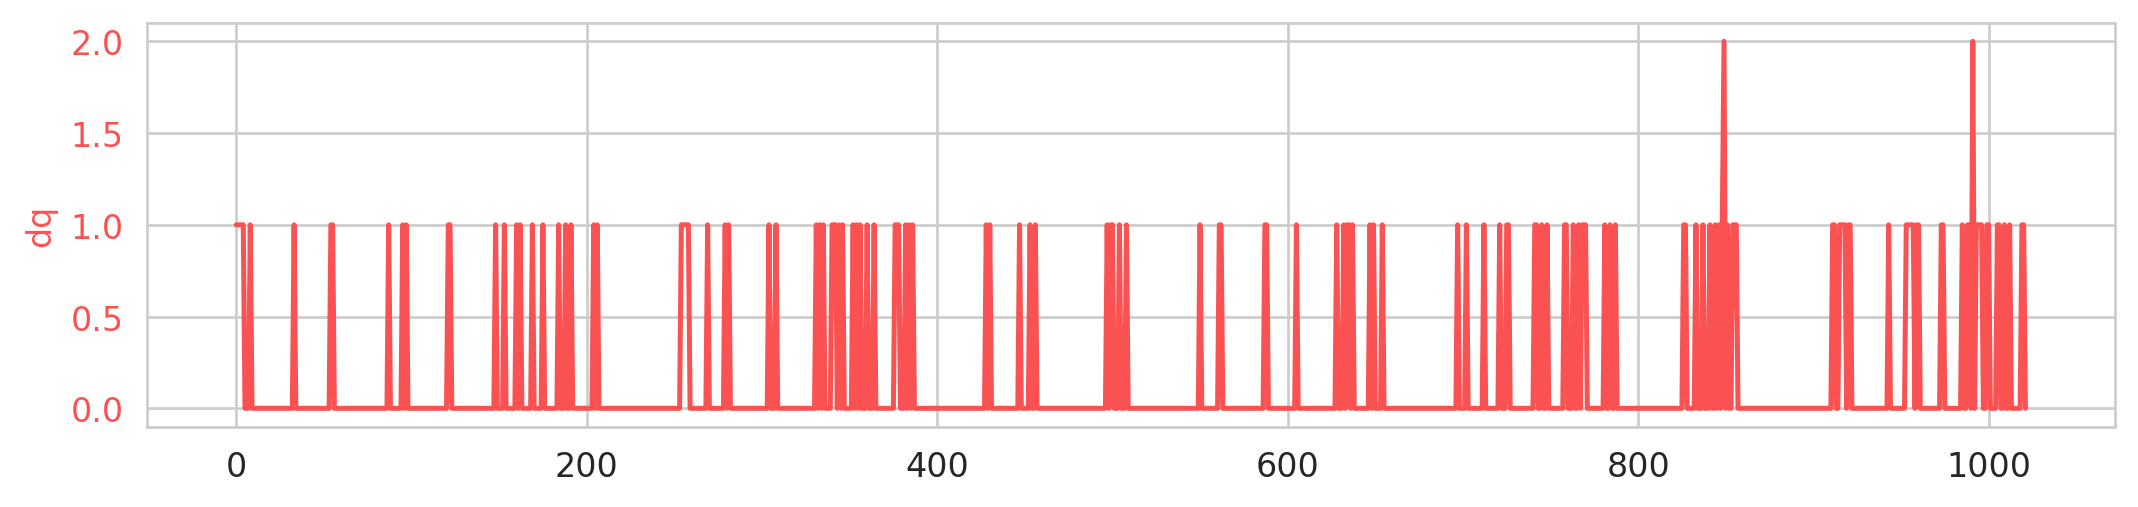

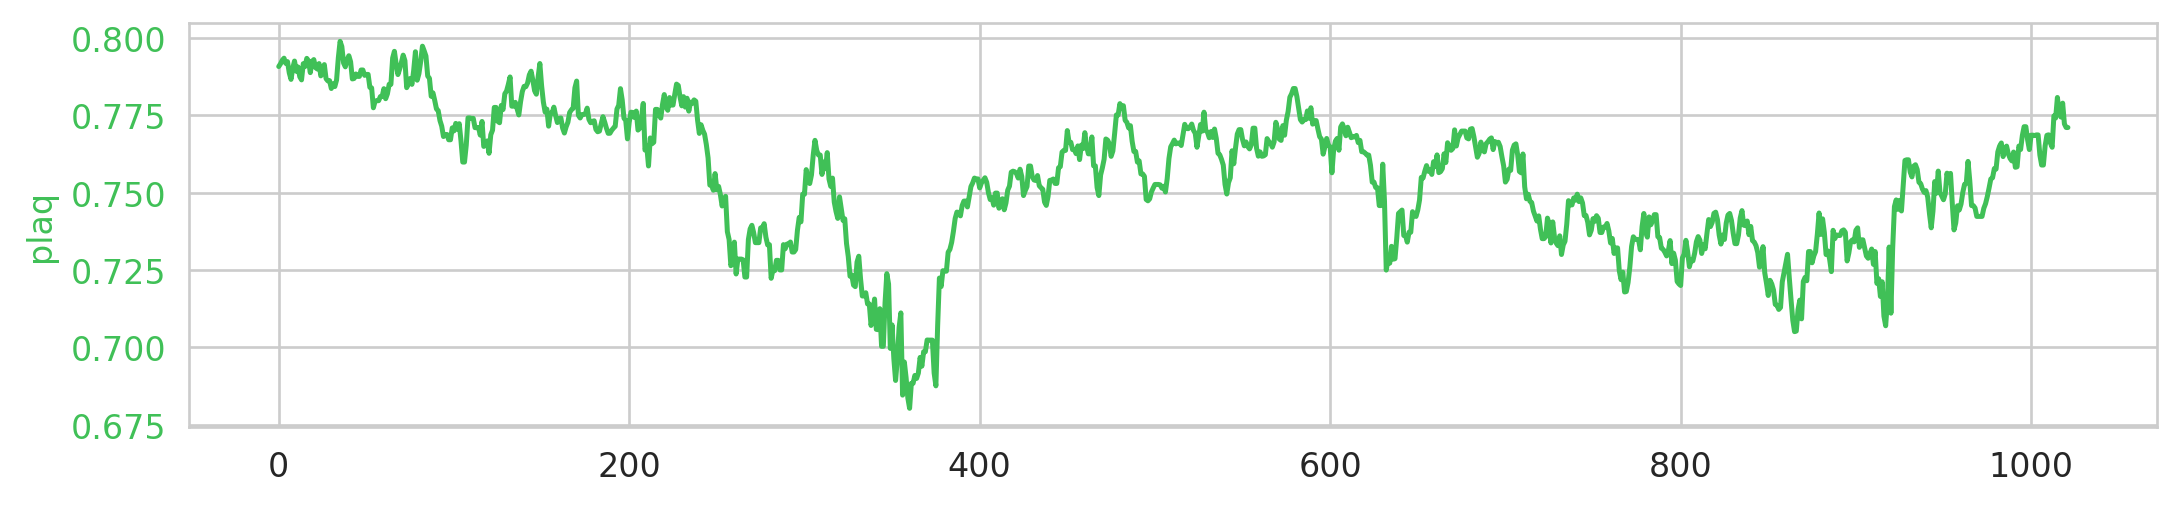

            traj=0 dt=0.188 acc=1.000 dh=0.245 plaq=0.791 q=-2.000 dq=1.000

[18:37:02]  traj=100 dt=0.187 acc=1.000 dh=-0.024 plaq=0.770 q=-1.000 dq=0.000

[18:37:37]  traj=200 dt=0.187 acc=1.000 dh=-0.151 plaq=0.773 q=0.000 dq=0.000

[18:38:10]  traj=300 dt=0.188 acc=0.000 dh=0.259 plaq=0.750 q=0.000 dq=0.000

[18:38:45]  traj=400 dt=0.188 acc=1.000 dh=0.076 plaq=0.752 q=-1.000 dq=0.000

[18:39:20]  traj=500 dt=0.187 acc=1.000 dh=-0.123 plaq=0.753 q=1.000 dq=1.000

[18:39:55]  traj=600 dt=0.188 acc=1.000 dh=0.234 plaq=0.765 q=0.000 dq=0.000

[18:40:30]  traj=700 dt=0.195 acc=1.000 dh=-0.080 plaq=0.753 q=0.000 dq=0.000

[18:41:05]  traj=800 dt=0.187 acc=1.000 dh=0.067 plaq=0.720 q=1.000 dq=0.000

[18:41:40]  traj=900 dt=0.188 acc=1.000 dh=-0.325 plaq=0.738 q=1.000 dq=0.000

[18:42:16]  traj=1000 dt=0.189 acc=1.000 dh=-0.082 plaq=0.769 q=0.000 dq=1.000

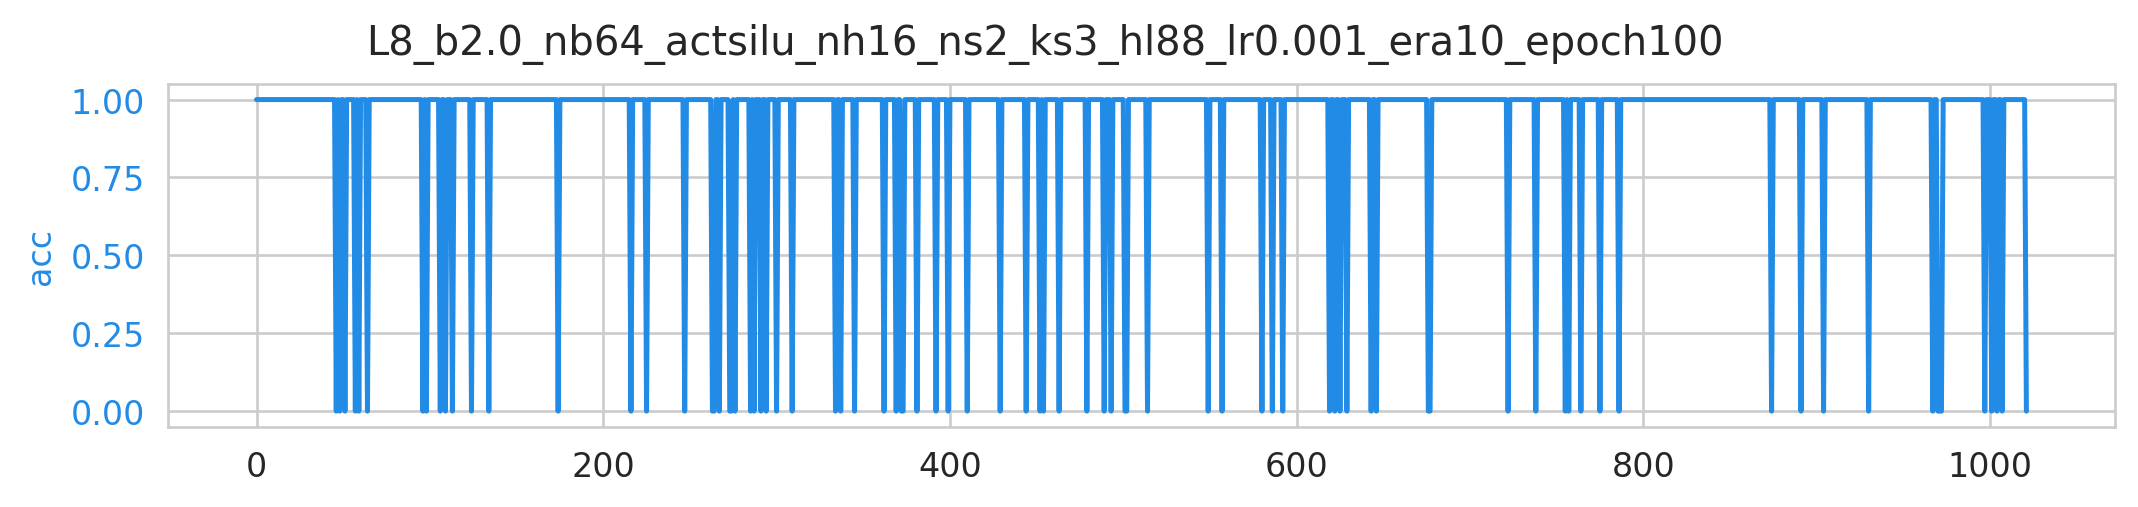

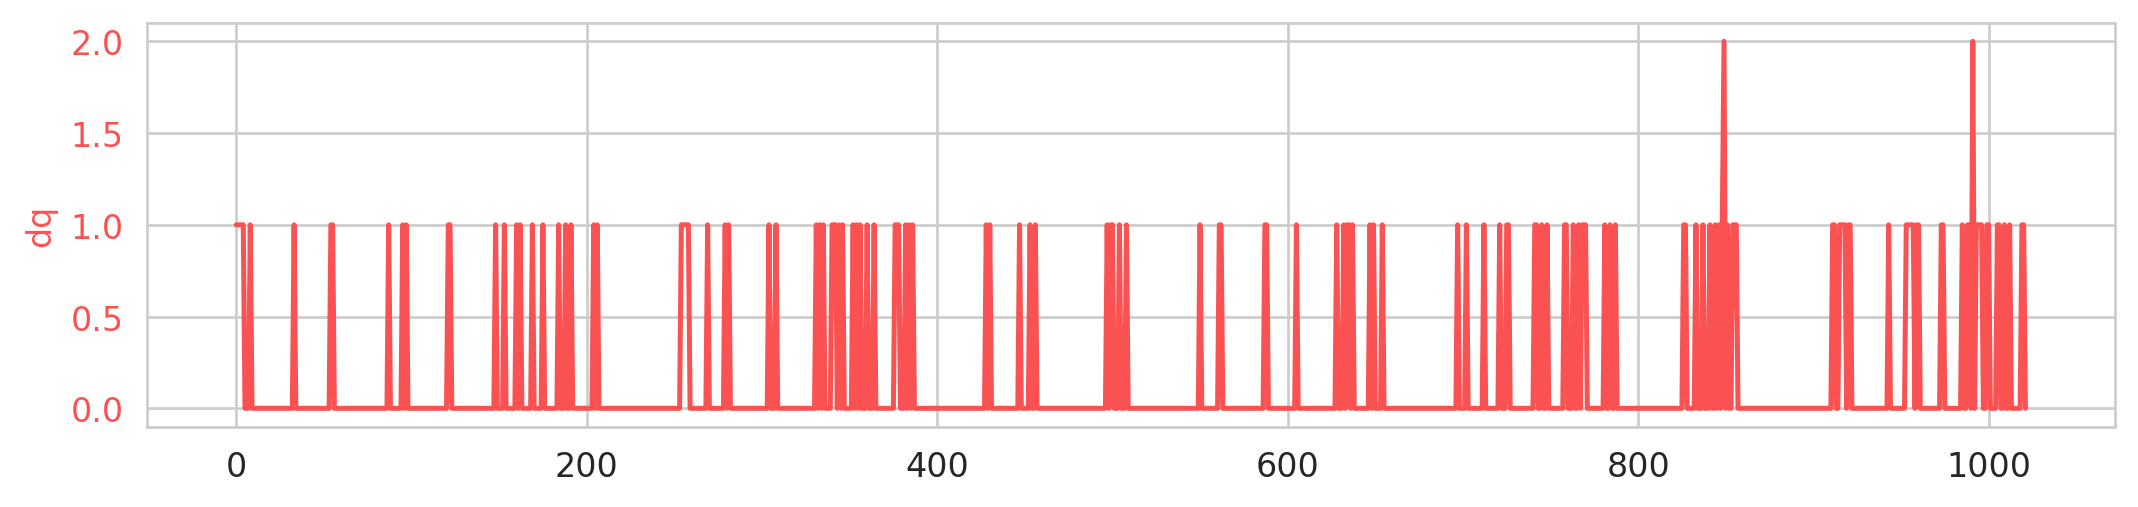

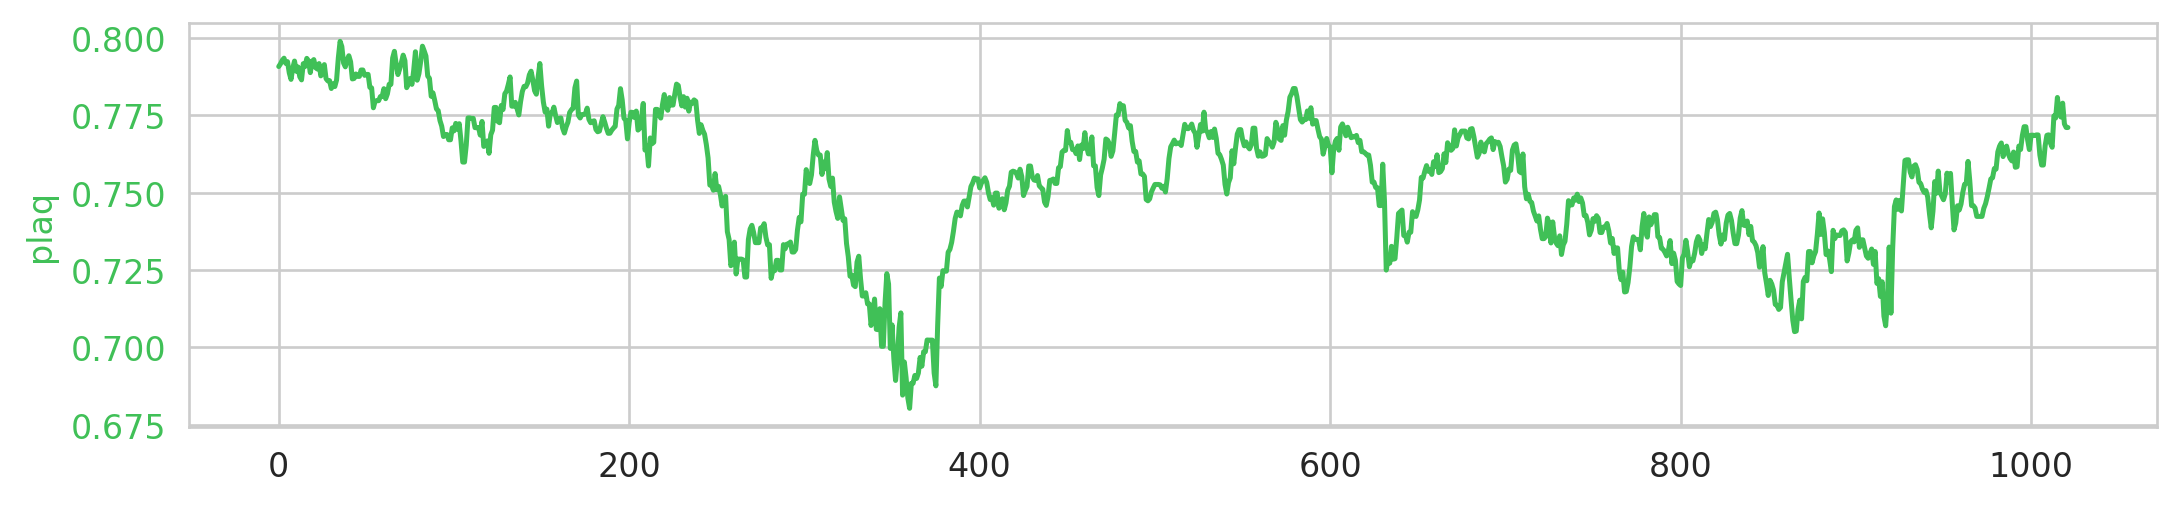

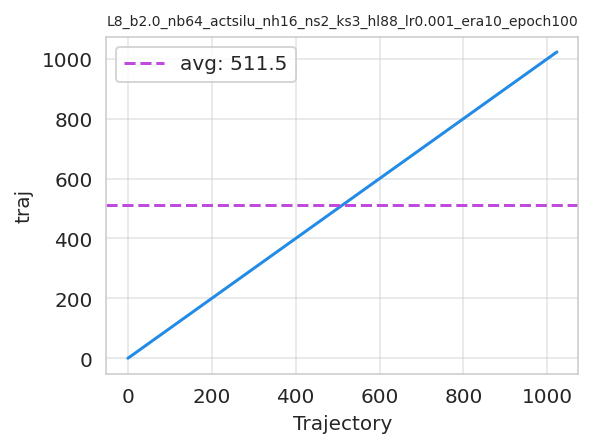

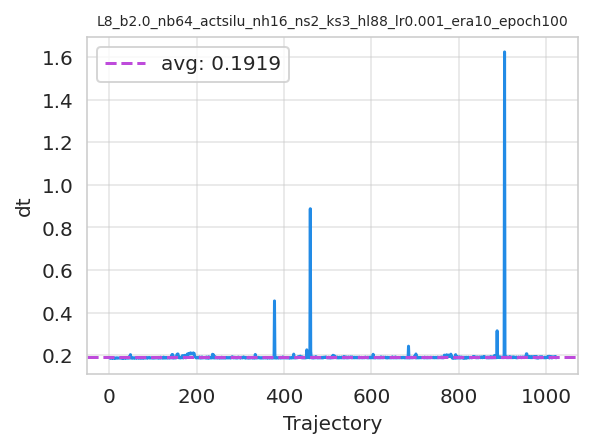

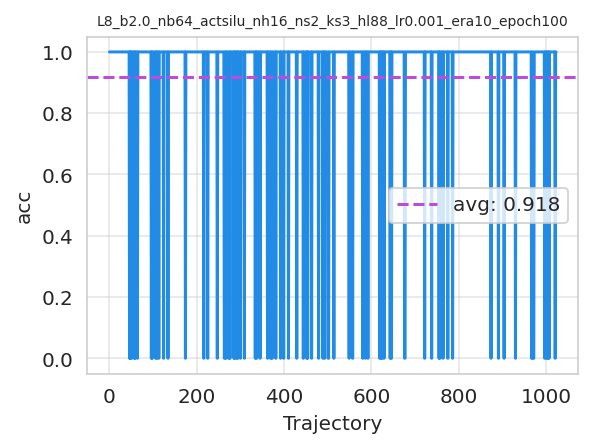

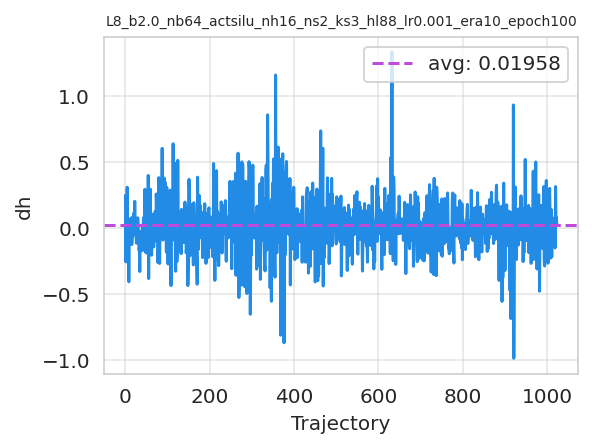

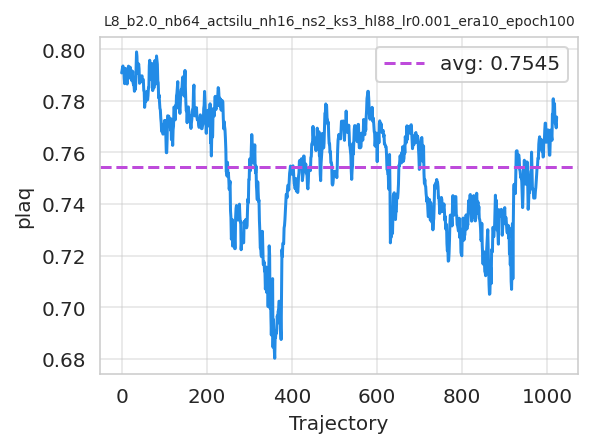

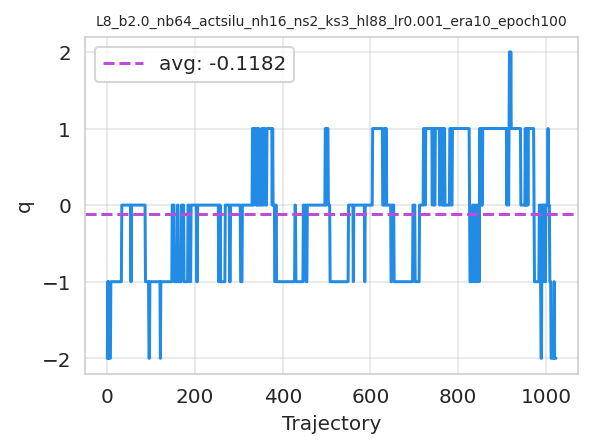

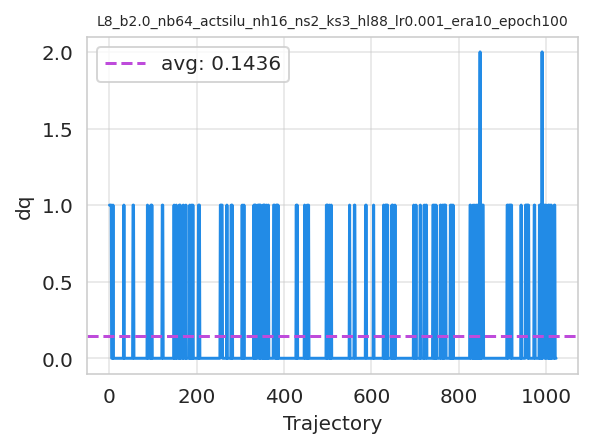

In [28]:
TAU = 0.05 #param.tau #0.1
NSTEP = 2 #param.nstep 
ftconfig = ftConfig(tau=TAU, nstep=NSTEP) 

flow = train_outputs['model'].layers
    
if torch.cuda.is_available():
    flow.to('cuda')
    
flow.eval()
field_transformation = FieldTransformation(flow=flow,
                                           config=train_config,
                                           ftconfig=ftconfig)

logdir = train_config.logdir
ftstr = ftconfig.uniquestr()
fthmcdir = os.path.join(logdir, 'ftHMC', ftstr)

pdir = os.path.join(fthmcdir, 'plots')
sdir = os.path.join(fthmcdir, 'summaries')

writer = SummaryWriter(log_dir=sdir)
logger.rule(f'Running `ftHMC` w/ tau={TAU:.2f}, nstep={NSTEP}')
runs_history = field_transformation.run(num_trajs=1024,
                                        nprint=100,
                                        #x=x_,
                                        figsize=(9., 2.),
                                        writer=writer,
                                        dpi=120, nplot=5, window=1)

#  Transfer to larger lattice


In [ ]:
from dataclasses import asdict
from fthmc.train import train, transfer_to_new_lattice

from torch import nn 

def transfer(
        L: int,
        param: Param,
        config: TrainConfig,
        scheduler_config: SchedulerConfig,
        layers: nn.ModuleList,
        new_lr: float = None,
        run_hmc: bool = True,
        figsize: tuple = None,
):
    if figsize is None:
        figsize = (9, 2)
        
    xfr = transfer_to_new_lattice(L=L,
                                  layers=layers,
                                  param_init=param)
    param_new = xfr['param']
    model_new = xfr['model']
    # ----------------------------------------------
    # Run HMC using new (transferred) `param` above
    # ----------------------------------------------
    if run_hmc:
        from fthmc.hmc import run_hmc
        hmc_fields, hmc_history = run_hmc(param_new)


    if new_lr is not None:
        cfg_dict = asdict(config)
        cfg_dict['base_lr'] = new_lr
        config_new = TrainConfig(**cfg_dict)
    else:
        config_new = config

    train_outputs = train(config_new,
                          model=model_new,
                          pre_model=None,
                          figsize=figsize,
                          scheduler_config=scheduler_config)
    return {
        'param': param_new,
        'config': config_new,
        'model': model_new,
        'outputs': train_outputs
    }

In [ ]:
layers8 = train_outputs['model'].layers #['layers']
layers8.train()
train_outputs16 = transfer(L=16, param=param,
                           config=train_config,
                           layers=layers8, 
                           scheduler_config=scheduler_config,
                           new_lr=0.0001, run_hmc=True)

## Run inference on trained model

In [ ]:
param16 = train_outputs16['param']
config16 = train_outputs16['config']
model16 = train_outputs16['model']
outputs16 = train_outputs16['outputs']

In [ ]:
action_fn16 = qed.BatchAction(param16.beta)

history16 = make_mcmc_ensemble(model=model16,
                               action_fn=action_fn16,
                               batch_size=config16.batch_size,
                               num_samples=8192)
plot_history(history=history16,
             param=param16, config=config16, skip=['epoch', 'x'],
             num_chains=4, therm_frac=0.0, xlabel='MC Step')#, outdir=inf_pdir8)

## Run `ftHMC` on trained model

In [ ]:
from dataclasses import asdict
from fthmc.utils.plot_helpers import update_plot
from fthmc.field_transformation import FieldTransformation
from fthmc.config import ftConfig

ftconfig16 = ftConfig(tau=0.05, nstep=2) 

flow16 = train_outputs16['model'].layers
    
if torch.cuda.is_available():
    flow16.to('cuda')
    
flow16.eval()
#pdict = asdict(param)
#pdict['tau'] = 0.1
#pdict['nstep'] = 5


field_transformation16 = FieldTransformation(flow=flow16, config=config16, ftconfig=ftconfig16)

In [ ]:
#x_ = hmc_fields[-1][-1].cuda()
x_ = field_transformation16.wrap(torch.zeros((1, 2, 16, 16)).uniform_(-np.pi, np.pi))

logdir16 = config16.logdir

ftstr16 = ftconfig16.uniquestr()
fthmcdir16 = os.path.join(logdir16, 'ftHMC', ftstr16)

pdir16 = os.path.join(fthmcdir16, 'plots')
sdir16 = os.path.join(fthmcdir16, 'summaries')

writer16 = SummaryWriter(log_dir=sdir16)

runs_history16 = field_transformation16.run(x=x_, nprint=50,
                                            figsize=(9., 2.),
                                            num_trajs=1024,
                                            writer=writer16,
                                            dpi=120, nplot=5, window=1)

In [ ]:

from dataclasses import asdict
from fthmc.utils.plot_helpers import update_plot
from fthmc.field_transformation import FieldTransformation

flow16 = model16.layers
    
if torch.cuda.is_available():
    flow16.to('cuda')
    
flow16.eval()

field_transformation16 = FieldTransformation(flow=flow16, param=param16)
x16_ = param16.initializer().cuda()
#x_ = hmc_fields[-1][-1].cuda()

runs_history = field_transformation16.run(x=x16_, nprint=50,
                                          figsize=(9., 2.),
                                          num_runs=2, num_trajs=1000,
                                          dpi=120, nplot=5, window=1)

In [ ]:
# ----------------------------------------------------------------
# Run inference on transferred model and evaluate / plot metrics
# ----------------------------------------------------------------
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history
from fthmc.utils.samplers import make_mcmc_ensemble

sns.set_context('paper')
action_fn8 = qed.BatchAction(param8.beta)
dirs8 = train_outputs8['dirs']
logdir8 = dirs8['logdir']

inf_dir8 = os.path.join(logdir8, 'inference')
inf_pdir8 = os.path.join(inf_dir8, 'plots')
history8 = make_mcmc_ensemble(model=train_outputs8['model'],
                               action_fn=action_fn8,
                               batch_size=train_config8.batch_size,
                               num_samples=1000)
plot_history(history=history8,
             param=param8, config=train_config8, skip=['epoch', 'x'],
             num_chains=4, therm_frac=0.0, xlabel='MC Step', outdir=inf_pdir8)

In [ ]:
%debug